# 1. Взаимодействую с ВМ Collab

In [ ]:
!git clone https://github.com/INLAE/RUT_futai.git

Cloning into 'RUT_futai'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 0), reused 23 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 8.83 KiB | 4.41 MiB/s, done.


In [ ]:
%cd RUT_futai

/content/RUT_futai


In [ ]:
%pip install -e .

Obtaining file:///content/RUT_futai
  Preparing metadata (setup.py) ... done
  Attempting uninstall: team_video_tracker
    Found existing installation: team_video_tracker 0.1.0
    Uninstalling team_video_tracker-0.1.0:
      Successfully uninstalled team_video_tracker-0.1.0
  Running setup.py develop for team_video_tracker


In [ ]:
import sys
sys.path.insert(0, '/content/RUT_futai/src')


# 2. Подключение основных библиотек и класса-пайплайна для обработки видео.

In [ ]:
import cv2
from tqdm import tqdm
from futai.processor import TeamVideoProcessor
from IPython.display import Video


# 3. Монтируется Drive, чтобы читать веса модели и видеофайл

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

WEIGHTS = '/content/drive/MyDrive/WEIGHTS/player-detection-best.pt'
VIDEO_IN   = '/content/drive/MyDrive/VIDEO/chunk_233.mp4'
VIDEO_OUT = "/content/annotated_res.mp4"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 4. Конфигурируется экземпляр TeamVideoProcessor: модель, видео и threshold.

### инициализация конвейера: детекция → трекинг → классификация → аннотация

In [ ]:
# инициализируем пайплайн
processor = TeamVideoProcessor(
    weights_path=WEIGHTS,
    video_path=VIDEO_IN,
    device='cuda',
    confidence=0.3
)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# 5. Извлекаем FPS и размер фрейма, чтобы VideoWriter совпадал с исходником.

In [ ]:
# читаем характеристики исходного видео

cap = cv2.VideoCapture(VIDEO_IN)
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

# 6. Создаётся объект для записи аннотированного видео в MP4 с теми же параметрами.

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out    = cv2.VideoWriter(VIDEO_OUT, fourcc, fps, (w, h))
print(f'VideoWriter: {fps:.2f} FPS, {w}×{h}')

VideoWriter: 50.00 FPS, 1280×720


# 7. Собрать огрызки и натренировать TeamClassifier

По умолчанию генератор выдаёт каждый кадр видео. Параметр stride=30 заставляет его перескакивать 29 кадров между выдачами, то есть он отдаёт только каждый 30-й кадр. Не буду тратить время на все 83481918 кадров ролика

Bytetrack хранит внутренние данные о предыдущих треках о том какой tracker_id присвоен какому объекту. При сборе кропов для обучения команд классификатором над, дабы трекер начинал с чистого листа и не смешивал данные с предыдущих прогонов

In [ ]:
from tqdm import tqdm
import supervision as sv
from futai.constants import PLAYER_CLASS_ID

# 1) Реинициализировать генератор (stride=30) и сбросить трекер
processor.gen = sv.get_video_frames_generator(VIDEO_IN, stride=30)
processor.tracker.reset()

# 2) Собрать все кропы игроков для обучения кластеризатора
crops = []
for frame in tqdm(processor.gen, desc='Collecting crops for fit'):
    dets = processor.detector.infer(frame, confidence=processor.confidence)
    players = dets[dets.class_id == PLAYER_CLASS_ID]
    for xy in players.xyxy:
        crops.append(sv.crop_image(frame, xy))

print(f'collected {len(crops)} player crops ept')

# 3) Фитим TeamClassifier один раз
processor.team_clf.fit(crops)
print('TeamClassifier жестко натренирован')


0: 736x1280 1 ball, 18 players, 73.7ms
Speed: 9.4ms preprocess, 73.7ms inference, 157.8ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 18 players, 1 referee, 50.7ms
Speed: 8.7ms preprocess, 50.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 17 players, 2 referees, 51.3ms
Speed: 5.7ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 20 players, 51.4ms
Speed: 5.7ms preprocess, 51.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 15 players, 51.6ms
Speed: 5.4ms preprocess, 51.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 17 players, 1 referee, 50.8ms
Speed: 5.3ms preprocess, 50.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 12 players, 2 referees, 50.7ms
Speed: 7.2ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 15 players, 1 referee, 50.9ms
Speed: 5.4ms preprocess, 50.9ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 14 players, 1 referee, 50.2ms
Speed: 7.5ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 9 players, 1 referee, 50.4ms
Speed: 5.9ms preprocess, 50.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 14 players, 1 referee, 50.9ms
Speed: 5.4ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 11 players, 51.4ms
Speed: 6.8ms preprocess, 51.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 11 players, 1 referee, 51.1ms
Speed: 5.5ms preprocess, 51.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 11 players, 2 referees, 51.5ms
Speed: 6.1ms preprocess, 51.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 12 players, 1 referee, 51.6ms
Speed: 6.3ms preprocess, 51.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 10 players, 51.1ms
Speed: 5.4ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 15 players, 51.5ms
Speed: 5.3ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 18 players, 1 referee, 50.9ms
Speed: 5.9ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 14 players, 3 referees, 51.0ms
Speed: 5.3ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 12 players, 51.4ms
Speed: 5.5ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 15 players, 50.3ms
Speed: 5.5ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 13 players, 1 referee, 50.6ms
Speed: 6.2ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 12 players, 51.2ms
Speed: 5.6ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 12 players, 2 referees, 51.7ms
Speed: 5.7ms preprocess, 51.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 15 players, 2 referees, 51.3ms
Speed: 5.5ms preprocess, 51.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 21 players, 1 referee, 50.3ms
Speed: 5.5ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 3 referees, 50.8ms
Speed: 6.4ms preprocess, 50.8ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 18 players, 1 referee, 50.6ms
Speed: 7.2ms preprocess, 50.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 16 players, 2 referees, 50.9ms
Speed: 5.6ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 16 players, 51.3ms
Speed: 7.7ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 19 players, 51.4ms
Speed: 5.5ms preprocess, 51.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 15 players, 1 referee, 51.4ms
Speed: 5.7ms preprocess, 51.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 17 players, 3 referees, 51.1ms
Speed: 6.1ms preprocess, 51.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 16 players, 51.4ms
Speed: 5.6ms preprocess, 51.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 15 players, 2 referees, 51.9ms
Speed: 6.5ms preprocess, 51.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 18 players, 1 referee, 50.9ms
Speed: 5.5ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 15 players, 2 referees, 50.9ms
Speed: 5.4ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 18 players, 3 referees, 50.8ms
Speed: 5.6ms preprocess, 50.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 1 referee, 50.8ms
Speed: 5.4ms preprocess, 50.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 14 players, 2 referees, 50.6ms
Speed: 5.8ms preprocess, 50.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 15 players, 50.2ms
Speed: 5.4ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 14 players, 1 referee, 50.7ms
Speed: 5.3ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 16 players, 1 referee, 50.6ms
Speed: 6.1ms preprocess, 50.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 18 players, 1 referee, 50.9ms
Speed: 5.8ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 19 players, 1 referee, 51.2ms
Speed: 5.4ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 ball, 21 players, 1 referee, 50.7ms
Speed: 5.3ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 50.6ms
Speed: 5.4ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 16 players, 50.9ms
Speed: 5.6ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 18 players, 1 referee, 51.3ms
Speed: 5.3ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



0: 736x1280 1 goalkeeper, 20 players, 1 referee, 51.4ms
Speed: 5.6ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Collected 765 player crops.



Embedding extraction: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]


✅ TeamClassifier натренирован.


## Посмотрим на рандомных N-кропов?

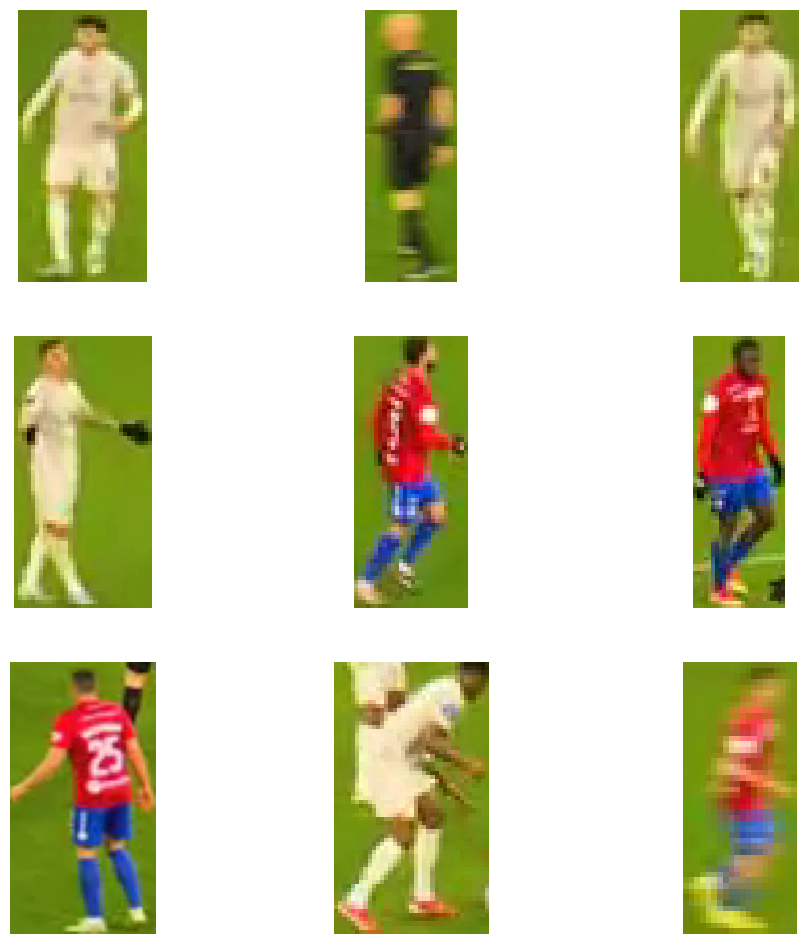

In [ ]:
import random
import supervision as sv

sampled = random.sample(crops, min(9, len(crops)))

sv.plot_images_grid(sampled, grid_size=(3, 3))

# 8. Фулл прогон видео и запись аннотированного результата


In [ ]:
# 1) Переинициализировать генератор без stride и сбросить трекер
processor.gen = sv.get_video_frames_generator(VIDEO_IN)  # теперь stride=1
processor.tracker.reset()

# 2) Цикл по всем кадрам
while True:
    try:
      # бери некс кадр
        _, ann = processor.process_next()
    except StopIteration:
        # пока видео не закончилось
        break
    # ann уже в BGR — сразу пишем в VideoWriter
    out.write(ann)

# 3) Закрыть VideoWriter
out.release()
print(f'Готово! Видео сохранено как {VIDEO_OUT}')


0: 736x1280 1 ball, 18 players, 50.8ms
Speed: 6.4ms preprocess, 50.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]



0: 736x1280 1 ball, 19 players, 1 referee, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

0: 736x1280 21 players, 1 referee, 51.1ms
Speed: 4.6ms preprocess, 51.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

0: 736x1280 19 players, 1 referee, 50.3ms
Speed: 4.4ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

0: 736x1280 19 players, 1 referee, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.2ms
Speed: 4.3ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

0: 736x1280 1 ball, 23 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 51.3ms
Speed: 5.7ms preprocess, 51.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.4ms
Speed: 4.7ms preprocess, 50.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 51.1ms
Speed: 4.6ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.5ms
Speed: 4.3ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

0: 736x1280 2 balls, 20 players, 2 referees, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.1ms
Speed: 5.0ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 51.3ms
Speed: 4.3ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.7ms
Speed: 4.3ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

0: 736x1280 1 ball, 18 players, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

0: 736x1280 1 ball, 21 players, 50.5ms
Speed: 4.6ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

0: 736x1280 1 ball, 19 players, 51.2ms
Speed: 4.7ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

0: 736x1280 1 ball, 20 players, 50.3ms
Speed: 4.3ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

0: 736x1280 23 players, 50.9ms
Speed: 4.8ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

0: 736x1280 21 players, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

0: 736x1280 19 players, 50.3ms
Speed: 4.3ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 50.3ms
Speed: 4.4ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.2ms
Speed: 5.1ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

0: 736x1280 1 ball, 22 players, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

0: 736x1280 1 ball, 20 players, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

0: 736x1280 1 ball, 22 players, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

0: 736x1280 1 ball, 22 players, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

0: 736x1280 1 ball, 22 players, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

0: 736x1280 1 ball, 27 players, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

0: 736x1280 2 balls, 24 players, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

0: 736x1280 22 players, 51.4ms
Speed: 4.5ms preprocess, 51.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

0: 736x1280 23 players, 50.2ms
Speed: 4.2ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

0: 736x1280 27 players, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

0: 736x1280 27 players, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

0: 736x1280 19 players, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

0: 736x1280 2 balls, 20 players, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 50.2ms
Speed: 5.0ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

0: 736x1280 1 ball, 22 players, 2 referees, 50.0ms
Speed: 4.5ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

0: 736x1280 2 balls, 18 players, 2 referees, 51.1ms
Speed: 4.7ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

0: 736x1280 2 balls, 21 players, 1 referee, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

0: 736x1280 1 ball, 23 players, 51.6ms
Speed: 4.3ms preprocess, 51.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

0: 736x1280 1 ball, 18 players, 3 referees, 50.7ms
Speed: 4.2ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

0: 736x1280 1 ball, 20 players, 50.7ms
Speed: 4.7ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

0: 736x1280 1 ball, 22 players, 50.7ms
Speed: 4.3ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

0: 736x1280 1 ball, 27 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.9ms
Speed: 4.2ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

0: 736x1280 1 ball, 23 players, 51.0ms
Speed: 4.4ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 51.1ms
Speed: 4.5ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 51.1ms
Speed: 4.4ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.8ms
Speed: 4.5ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 51.5ms
Speed: 4.8ms preprocess, 51.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

0: 736x1280 1 ball, 20 players, 2 referees, 50.6ms
Speed: 4.4ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 51.0ms
Speed: 4.3ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]

0: 736x1280 1 ball, 20 players, 2 referees, 50.9ms
Speed: 4.3ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.6ms
Speed: 4.2ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

0: 736x1280 21 players, 51.1ms
Speed: 5.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

0: 736x1280 18 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

0: 736x1280 17 players, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

0: 736x1280 18 players, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

0: 736x1280 18 players, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

0: 736x1280 19 players, 1 referee, 50.4ms
Speed: 4.5ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

0: 736x1280 22 players, 50.3ms
Speed: 4.3ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

0: 736x1280 19 players, 1 referee, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

0: 736x1280 19 players, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

0: 736x1280 1 ball, 18 players, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

0: 736x1280 1 ball, 19 players, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

0: 736x1280 2 balls, 18 players, 51.3ms
Speed: 4.3ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

0: 736x1280 2 balls, 21 players, 51.1ms
Speed: 4.3ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

0: 736x1280 1 ball, 20 players, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

0: 736x1280 1 ball, 18 players, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

0: 736x1280 1 ball, 17 players, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

0: 736x1280 2 balls, 22 players, 1 referee, 50.3ms
Speed: 4.3ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

0: 736x1280 2 balls, 19 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

0: 736x1280 2 balls, 20 players, 1 referee, 50.6ms
Speed: 4.7ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

0: 736x1280 1 ball, 20 players, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

0: 736x1280 1 ball, 23 players, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

0: 736x1280 1 ball, 20 players, 51.0ms
Speed: 4.5ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

0: 736x1280 1 ball, 20 players, 51.2ms
Speed: 4.4ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

0: 736x1280 2 balls, 22 players, 50.7ms
Speed: 4.4ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

0: 736x1280 1 ball, 22 players, 50.9ms
Speed: 4.2ms preprocess, 50.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

0: 736x1280 1 ball, 23 players, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

0: 736x1280 1 ball, 22 players, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

0: 736x1280 1 ball, 21 players, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

0: 736x1280 1 ball, 17 players, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

0: 736x1280 1 ball, 21 players, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

0: 736x1280 2 balls, 18 players, 1 referee, 50.5ms
Speed: 4.4ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

0: 736x1280 1 ball, 19 players, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

0: 736x1280 1 ball, 16 players, 1 referee, 51.1ms
Speed: 4.3ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


0: 736x1280 2 balls, 18 players, 51.2ms
Speed: 4.2ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


0: 736x1280 1 ball, 18 players, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]



0: 736x1280 2 balls, 15 players, 50.5ms
Speed: 4.4ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


0: 736x1280 2 balls, 15 players, 50.2ms
Speed: 4.2ms preprocess, 50.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


0: 736x1280 1 ball, 18 players, 51.2ms
Speed: 4.2ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


0: 736x1280 1 ball, 14 players, 2 referees, 51.4ms
Speed: 4.6ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


0: 736x1280 1 ball, 16 players, 1 referee, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


0: 736x1280 1 ball, 16 players, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


0: 736x1280 1 ball, 18 players, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


0: 736x1280 1 ball, 17 players, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


0: 736x1280 2 balls, 16 players, 50.7ms
Speed: 4.2ms preprocess, 50.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

0: 736x1280 1 ball, 17 players, 50.5ms
Speed: 5.4ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 17 players, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


0: 736x1280 1 ball, 15 players, 51.0ms
Speed: 5.0ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]



0: 736x1280 1 ball, 20 players, 50.9ms
Speed: 5.2ms preprocess, 50.9ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]



0: 736x1280 2 balls, 15 players, 51.3ms
Speed: 5.1ms preprocess, 51.3ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]



0: 736x1280 1 ball, 15 players, 50.3ms
Speed: 5.0ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]



0: 736x1280 1 ball, 14 players, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]



0: 736x1280 1 ball, 15 players, 51.9ms
Speed: 4.0ms preprocess, 51.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]



0: 736x1280 1 ball, 16 players, 51.7ms
Speed: 4.2ms preprocess, 51.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]



0: 736x1280 1 ball, 19 players, 50.2ms
Speed: 4.8ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]



0: 736x1280 1 ball, 20 players, 1 referee, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]



0: 736x1280 1 ball, 20 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]



0: 736x1280 14 players, 52.2ms
Speed: 4.0ms preprocess, 52.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]



0: 736x1280 15 players, 50.6ms
Speed: 4.2ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]



0: 736x1280 1 ball, 12 players, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]



0: 736x1280 1 ball, 13 players, 50.9ms
Speed: 4.9ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]



0: 736x1280 1 ball, 12 players, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]



0: 736x1280 2 balls, 13 players, 51.8ms
Speed: 4.7ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]



0: 736x1280 2 balls, 13 players, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.3ms
Speed: 3.9ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]



0: 736x1280 1 ball, 13 players, 50.7ms
Speed: 5.3ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]



0: 736x1280 1 ball, 13 players, 52.1ms
Speed: 3.9ms preprocess, 52.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s]



0: 736x1280 1 ball, 13 players, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]



0: 736x1280 1 ball, 14 players, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]



0: 736x1280 1 ball, 15 players, 50.4ms
Speed: 5.0ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]



0: 736x1280 1 ball, 15 players, 50.6ms
Speed: 4.3ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]



0: 736x1280 1 ball, 15 players, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]



0: 736x1280 1 ball, 16 players, 50.5ms
Speed: 4.5ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.72it/s]

0: 736x1280 1 ball, 11 players, 50.6ms
Speed: 3.8ms preprocess, 50.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]

0: 736x1280 1 ball, 12 players, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]

0: 736x1280 1 ball, 14 players, 51.8ms
Speed: 4.0ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]

0: 736x1280 1 ball, 15 players, 51.5ms
Speed: 4.7ms preprocess, 51.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s]

0: 736x1280 1 ball, 14 players, 51.7ms
Speed: 3.8ms preprocess, 51.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]



0: 736x1280 1 ball, 15 players, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 50.1ms
Speed: 4.2ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s]

0: 736x1280 1 ball, 18 players, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]

0: 736x1280 1 ball, 16 players, 1 referee, 51.8ms
Speed: 4.2ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 51.7ms
Speed: 4.6ms preprocess, 51.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]

0: 736x1280 1 ball, 13 players, 1 referee, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.5ms
Speed: 4.0ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]



0: 736x1280 1 ball, 15 players, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]



0: 736x1280 1 ball, 14 players, 51.1ms
Speed: 5.3ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s]

0: 736x1280 1 ball, 18 players, 51.6ms
Speed: 4.7ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]



0: 736x1280 1 ball, 14 players, 50.7ms
Speed: 4.7ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]

0: 736x1280 2 balls, 10 players, 1 referee, 51.8ms
Speed: 5.3ms preprocess, 51.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]

0: 736x1280 2 balls, 10 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]

0: 736x1280 1 ball, 9 players, 1 referee, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]

0: 736x1280 9 players, 52.2ms
Speed: 4.2ms preprocess, 52.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]

0: 736x1280 1 ball, 11 players, 50.6ms
Speed: 5.6ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]

0: 736x1280 12 players, 2 referees, 51.0ms
Speed: 5.0ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]

0: 736x1280 12 players, 1 referee, 51.3ms
Speed: 4.7ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s]

0: 736x1280 14 players, 2 referees, 51.8ms
Speed: 4.0ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]

0: 736x1280 10 players, 2 referees, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]

0: 736x1280 12 players, 3 referees, 51.7ms
Speed: 4.1ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]

0: 736x1280 1 ball, 14 players, 1 referee, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.94it/s]

0: 736x1280 1 ball, 13 players, 1 referee, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.94it/s]

0: 736x1280 1 ball, 15 players, 1 referee, 51.5ms
Speed: 4.1ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.91it/s]

0: 736x1280 1 ball, 12 players, 1 referee, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s]

0: 736x1280 1 ball, 11 players, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]

0: 736x1280 3 balls, 10 players, 2 referees, 51.7ms
Speed: 4.3ms preprocess, 51.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.03it/s]

0: 736x1280 2 balls, 12 players, 2 referees, 51.8ms
Speed: 4.5ms preprocess, 51.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]

0: 736x1280 2 balls, 18 players, 2 referees, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]

0: 736x1280 1 ball, 13 players, 2 referees, 51.6ms
Speed: 4.2ms preprocess, 51.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]

0: 736x1280 2 balls, 13 players, 1 referee, 50.5ms
Speed: 5.0ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]

0: 736x1280 1 ball, 12 players, 2 referees, 51.8ms
Speed: 3.8ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]

0: 736x1280 1 ball, 12 players, 2 referees, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]

0: 736x1280 13 players, 2 referees, 52.0ms
Speed: 4.2ms preprocess, 52.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]

0: 736x1280 13 players, 3 referees, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]

0: 736x1280 12 players, 3 referees, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]

0: 736x1280 1 ball, 14 players, 2 referees, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]

0: 736x1280 1 ball, 11 players, 2 referees, 50.1ms
Speed: 4.6ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]

0: 736x1280 1 ball, 10 players, 4 referees, 51.1ms
Speed: 4.3ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]

0: 736x1280 1 ball, 12 players, 1 referee, 50.4ms
Speed: 5.8ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]

0: 736x1280 1 ball, 9 players, 1 referee, 51.9ms
Speed: 4.0ms preprocess, 51.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]

0: 736x1280 1 ball, 15 players, 1 referee, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 50.2ms
Speed: 5.1ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]

0: 736x1280 1 ball, 16 players, 1 referee, 51.5ms
Speed: 5.5ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]

0: 736x1280 1 ball, 15 players, 3 referees, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]

0: 736x1280 1 ball, 12 players, 1 referee, 50.3ms
Speed: 5.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]

0: 736x1280 1 ball, 15 players, 1 referee, 50.5ms
Speed: 4.4ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]

0: 736x1280 1 ball, 16 players, 51.6ms
Speed: 4.2ms preprocess, 51.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 50.3ms
Speed: 4.2ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]

0: 736x1280 1 ball, 12 players, 50.0ms
Speed: 4.2ms preprocess, 50.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]

0: 736x1280 1 ball, 11 players, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]

0: 736x1280 1 ball, 10 players, 50.0ms
Speed: 4.3ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]

0: 736x1280 1 ball, 9 players, 51.3ms
Speed: 4.4ms preprocess, 51.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]

0: 736x1280 2 balls, 11 players, 51.8ms
Speed: 4.6ms preprocess, 51.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]

0: 736x1280 1 ball, 9 players, 51.1ms
Speed: 4.8ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]

0: 736x1280 1 ball, 9 players, 1 referee, 51.2ms
Speed: 6.3ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]

0: 736x1280 2 balls, 15 players, 51.0ms
Speed: 5.1ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.3ms
Speed: 4.7ms preprocess, 50.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.59it/s]

0: 736x1280 1 ball, 12 players, 50.5ms
Speed: 3.9ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]

0: 736x1280 1 ball, 11 players, 50.9ms
Speed: 4.2ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.19it/s]

0: 736x1280 1 ball, 15 players, 1 referee, 50.8ms
Speed: 3.9ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.43it/s]

0: 736x1280 1 ball, 14 players, 51.9ms
Speed: 3.8ms preprocess, 51.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]

0: 736x1280 1 ball, 12 players, 50.6ms
Speed: 5.1ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]

0: 736x1280 1 ball, 16 players, 1 referee, 51.1ms
Speed: 5.5ms preprocess, 51.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.9ms
Speed: 3.9ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s]

0: 736x1280 1 ball, 14 players, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]

0: 736x1280 1 ball, 13 players, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.93it/s]



0: 736x1280 1 ball, 9 players, 51.5ms
Speed: 4.0ms preprocess, 51.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]

0: 736x1280 1 ball, 10 players, 50.3ms
Speed: 4.8ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]

0: 736x1280 1 ball, 12 players, 51.4ms
Speed: 4.7ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]

0: 736x1280 1 ball, 11 players, 50.2ms
Speed: 4.4ms preprocess, 50.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]

0: 736x1280 1 ball, 11 players, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]

0: 736x1280 1 ball, 11 players, 2 referees, 50.3ms
Speed: 3.9ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]

0: 736x1280 1 ball, 14 players, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]

0: 736x1280 1 ball, 13 players, 1 referee, 51.5ms
Speed: 5.0ms preprocess, 51.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]

0: 736x1280 1 ball, 10 players, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]

0: 736x1280 1 ball, 14 players, 1 referee, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]

0: 736x1280 1 ball, 12 players, 1 referee, 51.0ms
Speed: 3.9ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s]



0: 736x1280 1 ball, 13 players, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]

0: 736x1280 1 ball, 13 players, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]

0: 736x1280 1 ball, 10 players, 51.6ms
Speed: 4.4ms preprocess, 51.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.92it/s]

0: 736x1280 1 ball, 14 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.6ms
Speed: 5.3ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.2ms
Speed: 4.3ms preprocess, 50.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.25it/s]



0: 736x1280 1 ball, 12 players, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]

0: 736x1280 1 ball, 10 players, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]

0: 736x1280 1 ball, 11 players, 51.0ms
Speed: 5.8ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]

0: 736x1280 1 ball, 12 players, 50.8ms
Speed: 4.3ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]

0: 736x1280 1 ball, 14 players, 1 referee, 51.7ms
Speed: 4.2ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]

0: 736x1280 1 ball, 14 players, 1 referee, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s]

0: 736x1280 1 ball, 13 players, 51.0ms
Speed: 4.8ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]

0: 736x1280 1 ball, 13 players, 50.8ms
Speed: 4.3ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s]

0: 736x1280 1 ball, 15 players, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]

0: 736x1280 1 ball, 14 players, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.14it/s]

0: 736x1280 1 ball, 13 players, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.73it/s]

0: 736x1280 1 ball, 15 players, 51.6ms
Speed: 4.0ms preprocess, 51.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.20it/s]



0: 736x1280 1 ball, 10 players, 50.0ms
Speed: 3.9ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]

0: 736x1280 1 ball, 8 players, 51.3ms
Speed: 3.9ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]

0: 736x1280 1 ball, 9 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]



0: 736x1280 1 ball, 9 players, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]



0: 736x1280 1 ball, 9 players, 51.4ms
Speed: 4.5ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]

0: 736x1280 1 ball, 11 players, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]

0: 736x1280 1 ball, 13 players, 51.6ms
Speed: 4.5ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]

0: 736x1280 1 ball, 10 players, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 50.8ms
Speed: 3.9ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]

0: 736x1280 1 ball, 13 players, 50.6ms
Speed: 5.1ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]

0: 736x1280 1 ball, 11 players, 51.2ms
Speed: 3.8ms preprocess, 51.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]

0: 736x1280 1 ball, 12 players, 50.8ms
Speed: 3.9ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]

0: 736x1280 1 ball, 9 players, 1 referee, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]

0: 736x1280 1 ball, 12 players, 1 referee, 51.5ms
Speed: 4.0ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]

0: 736x1280 2 balls, 9 players, 1 referee, 51.1ms
Speed: 3.8ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]

0: 736x1280 1 ball, 12 players, 1 referee, 50.4ms
Speed: 4.5ms preprocess, 50.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]

0: 736x1280 1 ball, 13 players, 2 referees, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]

0: 736x1280 1 ball, 13 players, 50.0ms
Speed: 4.1ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]

0: 736x1280 1 ball, 14 players, 1 referee, 51.6ms
Speed: 4.0ms preprocess, 51.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]

0: 736x1280 1 ball, 9 players, 1 referee, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]

0: 736x1280 1 ball, 9 players, 1 referee, 51.7ms
Speed: 3.9ms preprocess, 51.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]

0: 736x1280 1 ball, 9 players, 1 referee, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.98it/s]

0: 736x1280 1 ball, 10 players, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]

0: 736x1280 1 ball, 9 players, 51.0ms
Speed: 5.5ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]

0: 736x1280 1 ball, 8 players, 52.3ms
Speed: 4.3ms preprocess, 52.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]



0: 736x1280 1 ball, 9 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]



0: 736x1280 1 ball, 10 players, 50.9ms
Speed: 4.9ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]

0: 736x1280 1 ball, 10 players, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]

0: 736x1280 1 ball, 9 players, 1 referee, 51.5ms
Speed: 4.4ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]

0: 736x1280 1 ball, 12 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]

0: 736x1280 1 ball, 10 players, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 19.91it/s]



0: 736x1280 1 ball, 9 players, 51.6ms
Speed: 4.0ms preprocess, 51.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]

0: 736x1280 1 ball, 10 players, 50.2ms
Speed: 4.2ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]

0: 736x1280 1 ball, 9 players, 1 referee, 51.9ms
Speed: 4.1ms preprocess, 51.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]

0: 736x1280 1 ball, 9 players, 1 referee, 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]

0: 736x1280 1 ball, 9 players, 52.0ms
Speed: 3.9ms preprocess, 52.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]

0: 736x1280 1 ball, 9 players, 50.5ms
Speed: 3.9ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 50.7ms
Speed: 5.3ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 51.1ms
Speed: 3.8ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 51.6ms
Speed: 4.7ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 51.4ms
Speed: 3.9ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.19it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 51.4ms
Speed: 4.3ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 50.8ms
Speed: 5.5ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]

0: 736x1280 1 ball, 12 players, 51.8ms
Speed: 4.0ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]

0: 736x1280 2 balls, 14 players, 50.5ms
Speed: 5.7ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]

0: 736x1280 1 ball, 13 players, 51.3ms
Speed: 3.9ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


0: 736x1280 1 ball, 10 players, 3 referees, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.79it/s]

0: 736x1280 1 ball, 13 players, 50.6ms
Speed: 5.6ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]

0: 736x1280 1 ball, 14 players, 1 referee, 51.5ms
Speed: 4.0ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 51.3ms
Speed: 4.7ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]

0: 736x1280 1 ball, 11 players, 2 referees, 50.3ms
Speed: 5.8ms preprocess, 50.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]

0: 736x1280 1 ball, 10 players, 3 referees, 50.7ms
Speed: 5.5ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]

0: 736x1280 1 ball, 11 players, 3 referees, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]

0: 736x1280 1 ball, 11 players, 2 referees, 50.6ms
Speed: 4.5ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s]

0: 736x1280 1 ball, 11 players, 3 referees, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]



0: 736x1280 1 ball, 13 players, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s]



0: 736x1280 1 ball, 15 players, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]

0: 736x1280 1 ball, 11 players, 49.8ms
Speed: 5.2ms preprocess, 49.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 50.1ms
Speed: 3.9ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 50.2ms
Speed: 3.9ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 50.2ms
Speed: 4.3ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.64it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 50.2ms
Speed: 4.2ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 50.1ms
Speed: 4.3ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]

0: 736x1280 1 ball, 11 players, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.97it/s]

0: 736x1280 1 ball, 10 players, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]

0: 736x1280 1 ball, 11 players, 2 referees, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 50.9ms
Speed: 5.1ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.97it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]



0: 736x1280 1 ball, 11 players, 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s]

0: 736x1280 1 ball, 10 players, 49.9ms
Speed: 4.5ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]

0: 736x1280 1 ball, 11 players, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 51.0ms
Speed: 4.5ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]



0: 736x1280 1 ball, 11 players, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.26it/s]



0: 736x1280 1 ball, 11 players, 51.2ms
Speed: 4.5ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s]



0: 736x1280 1 ball, 11 players, 49.9ms
Speed: 4.5ms preprocess, 49.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]



0: 736x1280 1 ball, 11 players, 51.1ms
Speed: 4.9ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 51.9ms
Speed: 4.0ms preprocess, 51.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.3ms
Speed: 4.2ms preprocess, 50.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]



0: 736x1280 1 ball, 11 players, 2 referees, 51.4ms
Speed: 4.3ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.5ms
Speed: 3.8ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 51.6ms
Speed: 3.9ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.45it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.2ms
Speed: 4.2ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]



0: 736x1280 14 players, 1 referee, 50.1ms
Speed: 5.9ms preprocess, 50.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.25it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]



0: 736x1280 1 ball, 11 players, 2 referees, 50.2ms
Speed: 4.2ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]



0: 736x1280 1 ball, 11 players, 3 referees, 51.7ms
Speed: 4.2ms preprocess, 51.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]



0: 736x1280 1 ball, 11 players, 2 referees, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]



0: 736x1280 1 ball, 11 players, 2 referees, 51.4ms
Speed: 4.3ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]



0: 736x1280 1 ball, 11 players, 2 referees, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]



0: 736x1280 1 ball, 12 players, 2 referees, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]



0: 736x1280 1 ball, 12 players, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 50.3ms
Speed: 5.6ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]



0: 736x1280 1 ball, 11 players, 2 referees, 51.2ms
Speed: 4.8ms preprocess, 51.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]



0: 736x1280 1 ball, 11 players, 2 referees, 50.7ms
Speed: 5.4ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 50.6ms
Speed: 4.2ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 51.7ms
Speed: 4.4ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 49.9ms
Speed: 4.3ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 51.5ms
Speed: 4.0ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.4ms
Speed: 4.3ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.5ms
Speed: 4.8ms preprocess, 50.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 51.2ms
Speed: 4.2ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.6ms
Speed: 4.3ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 51.9ms
Speed: 3.9ms preprocess, 51.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 49.8ms
Speed: 4.0ms preprocess, 49.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 51.4ms
Speed: 4.4ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.26it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.3ms
Speed: 3.9ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]



0: 736x1280 1 ball, 11 players, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]



0: 736x1280 1 ball, 12 players, 51.6ms
Speed: 4.2ms preprocess, 51.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.9ms
Speed: 4.3ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]



0: 736x1280 1 ball, 12 players, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.1ms
Speed: 4.7ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]



0: 736x1280 1 ball, 11 players, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]



0: 736x1280 1 ball, 12 players, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.6ms
Speed: 4.0ms preprocess, 51.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 51.6ms
Speed: 4.3ms preprocess, 51.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 51.4ms
Speed: 4.3ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]



0: 736x1280 1 ball, 11 players, 2 referees, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]

0: 736x1280 1 ball, 12 players, 1 referee, 51.4ms
Speed: 4.4ms preprocess, 51.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 49.8ms
Speed: 4.0ms preprocess, 49.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 51.5ms
Speed: 4.0ms preprocess, 51.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.9ms
Speed: 4.0ms preprocess, 51.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]



0: 736x1280 2 balls, 13 players, 1 referee, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]



0: 736x1280 12 players, 1 referee, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]



0: 736x1280 12 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]



0: 736x1280 12 players, 1 referee, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]



0: 736x1280 13 players, 1 referee, 50.2ms
Speed: 5.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]



0: 736x1280 13 players, 1 referee, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]



0: 736x1280 11 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]



0: 736x1280 11 players, 1 referee, 50.9ms
Speed: 4.2ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.3ms
Speed: 3.9ms preprocess, 50.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.7ms
Speed: 5.7ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.1ms
Speed: 3.9ms preprocess, 50.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 51.5ms
Speed: 4.1ms preprocess, 51.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]



0: 736x1280 11 players, 1 referee, 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]



0: 736x1280 12 players, 1 referee, 51.8ms
Speed: 4.0ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.5ms
Speed: 4.0ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 49.9ms
Speed: 4.0ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.5ms
Speed: 4.3ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.2ms
Speed: 4.8ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.0ms
Speed: 4.9ms preprocess, 51.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.0ms
Speed: 4.8ms preprocess, 51.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]



0: 736x1280 11 players, 49.9ms
Speed: 4.2ms preprocess, 49.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]



0: 736x1280 11 players, 1 referee, 51.2ms
Speed: 5.8ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]



0: 736x1280 11 players, 50.6ms
Speed: 4.2ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]



0: 736x1280 1 ball, 13 players, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]



0: 736x1280 1 ball, 13 players, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]



0: 736x1280 1 ball, 12 players, 50.0ms
Speed: 4.4ms preprocess, 50.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s]



0: 736x1280 2 balls, 11 players, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]



0: 736x1280 1 ball, 11 players, 51.1ms
Speed: 4.5ms preprocess, 51.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s]



0: 736x1280 1 ball, 12 players, 50.7ms
Speed: 4.8ms preprocess, 50.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]



0: 736x1280 2 balls, 11 players, 50.3ms
Speed: 4.2ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.94it/s]



0: 736x1280 2 balls, 11 players, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]



0: 736x1280 1 ball, 12 players, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]



0: 736x1280 1 ball, 11 players, 51.5ms
Speed: 4.3ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]



0: 736x1280 1 ball, 11 players, 50.2ms
Speed: 4.3ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]



0: 736x1280 1 ball, 11 players, 51.7ms
Speed: 4.2ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s]



0: 736x1280 1 ball, 11 players, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]



0: 736x1280 1 ball, 12 players, 51.7ms
Speed: 4.2ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]



0: 736x1280 1 ball, 11 players, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.39it/s]



0: 736x1280 1 ball, 12 players, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]



0: 736x1280 1 ball, 11 players, 50.5ms
Speed: 5.0ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]



0: 736x1280 1 ball, 11 players, 51.5ms
Speed: 4.2ms preprocess, 51.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]



0: 736x1280 1 ball, 11 players, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]



0: 736x1280 1 ball, 11 players, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.26it/s]



0: 736x1280 1 ball, 11 players, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]

0: 736x1280 1 ball, 10 players, 49.8ms
Speed: 5.0ms preprocess, 49.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]

0: 736x1280 1 ball, 10 players, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]

0: 736x1280 1 ball, 11 players, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]

0: 736x1280 1 ball, 11 players, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.92it/s]

0: 736x1280 11 players, 1 referee, 51.3ms
Speed: 4.3ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]



0: 736x1280 1 ball, 12 players, 50.3ms
Speed: 5.3ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]



0: 736x1280 12 players, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]



0: 736x1280 12 players, 50.3ms
Speed: 4.6ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]



0: 736x1280 12 players, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]



0: 736x1280 12 players, 1 referee, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.8ms
Speed: 3.9ms preprocess, 51.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.3ms
Speed: 5.3ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.5ms
Speed: 4.1ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]



0: 736x1280 12 players, 1 referee, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]



0: 736x1280 12 players, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]



0: 736x1280 12 players, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]



0: 736x1280 12 players, 50.3ms
Speed: 4.3ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]



0: 736x1280 12 players, 50.1ms
Speed: 5.3ms preprocess, 50.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]



0: 736x1280 12 players, 50.0ms
Speed: 5.1ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]



0: 736x1280 13 players, 50.4ms
Speed: 5.6ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]



0: 736x1280 13 players, 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]



0: 736x1280 13 players, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]



0: 736x1280 13 players, 50.6ms
Speed: 3.8ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]



0: 736x1280 14 players, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]



0: 736x1280 13 players, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]



0: 736x1280 15 players, 51.2ms
Speed: 3.9ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]



0: 736x1280 13 players, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]



0: 736x1280 13 players, 51.0ms
Speed: 4.4ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]



0: 736x1280 13 players, 51.0ms
Speed: 5.4ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]



0: 736x1280 15 players, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]



0: 736x1280 15 players, 50.8ms
Speed: 4.3ms preprocess, 50.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]



0: 736x1280 15 players, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]



0: 736x1280 14 players, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]



0: 736x1280 15 players, 50.9ms
Speed: 4.2ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]



0: 736x1280 14 players, 51.4ms
Speed: 4.4ms preprocess, 51.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]



0: 736x1280 14 players, 1 referee, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]



0: 736x1280 13 players, 1 referee, 50.7ms
Speed: 5.1ms preprocess, 50.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.9ms
Speed: 5.8ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]



0: 736x1280 16 players, 51.2ms
Speed: 4.5ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]



0: 736x1280 15 players, 50.9ms
Speed: 5.3ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]



0: 736x1280 16 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


0: 736x1280 16 players, 1 referee, 50.3ms
Speed: 4.2ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]



0: 736x1280 15 players, 1 referee, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


0: 736x1280 1 ball, 15 players, 1 referee, 50.1ms


Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


0: 736x1280 1 ball, 15 players, 50.4ms
Speed: 5.7ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

0: 736x1280 15 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]



0: 736x1280 15 players, 1 referee, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


0: 736x1280 1 ball, 15 players, 1 referee, 50.3ms
Speed: 5.1ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


0: 736x1280 1 ball, 17 players, 1 referee, 50.4ms
Speed: 3.9ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]



0: 736x1280 1 ball, 16 players, 50.9ms
Speed: 4.3ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.7ms
Speed: 5.8ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.0ms
Speed: 5.4ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


0: 736x1280 1 ball, 16 players, 1 referee, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.2ms
Speed: 4.5ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


0: 736x1280 1 ball, 16 players, 1 referee, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]



0: 736x1280 18 players, 1 referee, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


0: 736x1280 16 players, 1 referee, 50.4ms
Speed: 4.9ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

0: 736x1280 16 players, 1 referee, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


0: 736x1280 17 players, 1 referee, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


0: 736x1280 16 players, 2 referees, 50.2ms
Speed: 5.3ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


0: 736x1280 1 ball, 15 players, 3 referees, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.5ms
Speed: 3.9ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 50.9ms
Speed: 4.3ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]



0: 736x1280 2 balls, 16 players, 2 referees, 50.8ms
Speed: 5.9ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 51.2ms
Speed: 5.5ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


0: 736x1280 1 ball, 16 players, 2 referees, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


0: 736x1280 1 ball, 15 players, 1 referee, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


0: 736x1280 1 ball, 13 players, 1 referee, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.1ms
Speed: 5.4ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]



0: 736x1280 1 ball, 18 players, 2 referees, 50.9ms
Speed: 5.6ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]



0: 736x1280 1 ball, 16 players, 3 referees, 51.0ms
Speed: 4.5ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]



0: 736x1280 1 ball, 19 players, 3 referees, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 50.9ms
Speed: 5.1ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 50.9ms
Speed: 5.5ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]



0: 736x1280 17 players, 2 referees, 50.2ms
Speed: 5.8ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]



0: 736x1280 1 ball, 16 players, 3 referees, 51.0ms
Speed: 4.5ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]



0: 736x1280 1 ball, 17 players, 2 referees, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]



0: 736x1280 2 balls, 15 players, 2 referees, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.2ms
Speed: 4.2ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]



0: 736x1280 1 ball, 14 players, 3 referees, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]



0: 736x1280 1 ball, 16 players, 3 referees, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]



0: 736x1280 1 ball, 15 players, 3 referees, 50.5ms
Speed: 4.3ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 50.5ms
Speed: 4.8ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.1ms
Speed: 3.9ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]



0: 736x1280 12 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]



0: 736x1280 12 players, 52.0ms
Speed: 4.5ms preprocess, 52.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]



0: 736x1280 12 players, 1 referee, 51.4ms
Speed: 5.8ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]



0: 736x1280 12 players, 51.4ms
Speed: 5.6ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]



0: 736x1280 11 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]



0: 736x1280 11 players, 1 referee, 50.9ms
Speed: 5.6ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]



0: 736x1280 12 players, 2 referees, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]



0: 736x1280 12 players, 2 referees, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]



0: 736x1280 12 players, 2 referees, 50.8ms
Speed: 4.3ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]



0: 736x1280 13 players, 1 referee, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]



0: 736x1280 14 players, 1 referee, 50.2ms
Speed: 3.9ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 14 players, 1 referee, 51.3ms
Speed: 4.3ms preprocess, 51.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]



0: 736x1280 14 players, 1 referee, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]



0: 736x1280 15 players, 1 referee, 51.1ms
Speed: 4.3ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]



0: 736x1280 14 players, 1 referee, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]



0: 736x1280 14 players, 1 referee, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]



0: 736x1280 13 players, 1 referee, 51.9ms
Speed: 4.0ms preprocess, 51.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]



0: 736x1280 17 players, 1 referee, 51.6ms
Speed: 4.4ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]



0: 736x1280 13 players, 1 referee, 50.9ms
Speed: 3.9ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]



0: 736x1280 12 players, 1 referee, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]



0: 736x1280 12 players, 50.2ms
Speed: 3.9ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]



0: 736x1280 14 players, 50.9ms
Speed: 4.2ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]



0: 736x1280 1 ball, 14 players, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]



0: 736x1280 13 players, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]



0: 736x1280 1 ball, 14 players, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]



0: 736x1280 14 players, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]



0: 736x1280 14 players, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]



0: 736x1280 13 players, 51.7ms
Speed: 4.1ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]



0: 736x1280 13 players, 51.0ms
Speed: 4.8ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]



0: 736x1280 14 players, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]



0: 736x1280 14 players, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]



0: 736x1280 15 players, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]



0: 736x1280 14 players, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]



0: 736x1280 14 players, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]



0: 736x1280 14 players, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]



0: 736x1280 14 players, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]



0: 736x1280 15 players, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]



0: 736x1280 14 players, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]



0: 736x1280 14 players, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]



0: 736x1280 15 players, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


0: 736x1280 15 players, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]



0: 736x1280 17 players, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


0: 736x1280 19 players, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

0: 736x1280 16 players, 50.0ms
Speed: 4.2ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]

0: 736x1280 16 players, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]

0: 736x1280 19 players, 50.2ms
Speed: 4.3ms preprocess, 50.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


0: 736x1280 16 players, 50.2ms
Speed: 4.3ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]



0: 736x1280 19 players, 1 referee, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]



0: 736x1280 15 players, 1 referee, 50.5ms
Speed: 4.4ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]



0: 736x1280 14 players, 1 referee, 51.9ms
Speed: 3.9ms preprocess, 51.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]



0: 736x1280 1 ball, 15 players, 51.3ms
Speed: 5.2ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]



0: 736x1280 1 ball, 16 players, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]



0: 736x1280 17 players, 1 referee, 50.2ms
Speed: 5.1ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]



0: 736x1280 1 ball, 19 players, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]



0: 736x1280 1 ball, 12 players, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]



0: 736x1280 1 ball, 14 players, 51.5ms
Speed: 4.3ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]



0: 736x1280 12 players, 2 referees, 51.5ms
Speed: 4.0ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]



0: 736x1280 14 players, 1 referee, 50.9ms
Speed: 5.0ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.4ms
Speed: 5.6ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]



0: 736x1280 17 players, 1 referee, 51.3ms
Speed: 3.9ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.98it/s]

0: 736x1280 16 players, 1 referee, 51.8ms
Speed: 4.4ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]



0: 736x1280 15 players, 1 referee, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]



0: 736x1280 16 players, 2 referees, 50.6ms
Speed: 4.2ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]



0: 736x1280 12 players, 1 referee, 51.6ms
Speed: 4.2ms preprocess, 51.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]

0: 736x1280 11 players, 1 referee, 51.1ms
Speed: 5.5ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.14it/s]

0: 736x1280 11 players, 1 referee, 51.1ms
Speed: 4.4ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]



0: 736x1280 11 players, 3 referees, 51.8ms
Speed: 4.1ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]

0: 736x1280 13 players, 1 referee, 51.4ms
Speed: 5.1ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.79it/s]



0: 736x1280 13 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.90it/s]



0: 736x1280 11 players, 1 referee, 51.5ms
Speed: 4.2ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s]

0: 736x1280 11 players, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]



0: 736x1280 10 players, 51.1ms
Speed: 5.6ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]

0: 736x1280 11 players, 51.4ms
Speed: 3.8ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.71it/s]

0: 736x1280 12 players, 1 referee, 51.9ms
Speed: 4.8ms preprocess, 51.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]

0: 736x1280 10 players, 1 referee, 51.7ms
Speed: 4.1ms preprocess, 51.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]

0: 736x1280 11 players, 2 referees, 51.6ms
Speed: 4.2ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]

0: 736x1280 10 players, 2 referees, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s]

0: 736x1280 10 players, 2 referees, 50.8ms
Speed: 4.4ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s]

0: 736x1280 11 players, 2 referees, 51.1ms
Speed: 4.8ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]

0: 736x1280 10 players, 1 referee, 51.0ms
Speed: 5.7ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]

0: 736x1280 13 players, 1 referee, 52.0ms
Speed: 4.1ms preprocess, 52.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]

0: 736x1280 1 ball, 10 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 52.1ms
Speed: 4.0ms preprocess, 52.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]

0: 736x1280 2 balls, 10 players, 1 referee, 50.6ms
Speed: 3.9ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]

0: 736x1280 1 ball, 10 players, 2 referees, 51.7ms
Speed: 3.9ms preprocess, 51.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]

0: 736x1280 1 ball, 11 players, 2 referees, 51.8ms
Speed: 4.1ms preprocess, 51.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]

0: 736x1280 1 ball, 13 players, 3 referees, 50.9ms
Speed: 4.2ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]



0: 736x1280 1 ball, 12 players, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.59it/s]

0: 736x1280 1 ball, 12 players, 1 referee, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]



0: 736x1280 1 ball, 10 players, 1 referee, 52.0ms
Speed: 4.0ms preprocess, 52.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.85it/s]

0: 736x1280 1 ball, 12 players, 1 referee, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 51.7ms
Speed: 4.3ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 50.5ms
Speed: 6.0ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s]

0: 736x1280 1 ball, 13 players, 1 referee, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 51.1ms
Speed: 4.4ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]

0: 736x1280 1 ball, 11 players, 1 referee, 51.6ms
Speed: 3.9ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]

0: 736x1280 1 ball, 12 players, 1 referee, 51.2ms
Speed: 3.9ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]



0: 736x1280 1 ball, 12 players, 1 referee, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]



0: 736x1280 14 players, 1 referee, 52.1ms
Speed: 4.7ms preprocess, 52.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]



0: 736x1280 15 players, 1 referee, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 50.3ms
Speed: 5.6ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 51.8ms
Speed: 4.0ms preprocess, 51.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.68it/s]



0: 736x1280 13 players, 1 referee, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]



0: 736x1280 1 ball, 12 players, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.8ms
Speed: 4.8ms preprocess, 51.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.1ms
Speed: 4.6ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.94it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 51.7ms
Speed: 4.1ms preprocess, 51.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]



0: 736x1280 1 ball, 12 players, 51.9ms
Speed: 4.0ms preprocess, 51.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]

0: 736x1280 1 ball, 12 players, 2 referees, 52.1ms
Speed: 4.4ms preprocess, 52.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]



0: 736x1280 1 ball, 11 players, 1 referee, 51.3ms
Speed: 5.8ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]



0: 736x1280 1 ball, 11 players, 2 referees, 50.9ms
Speed: 4.2ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 52.1ms
Speed: 4.0ms preprocess, 52.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]



0: 736x1280 18 players, 2 referees, 51.7ms
Speed: 4.6ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 51.4ms
Speed: 4.3ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]



0: 736x1280 14 players, 2 referees, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]



0: 736x1280 1 ball, 12 players, 2 referees, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]



0: 736x1280 11 players, 1 referee, 51.8ms
Speed: 4.0ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]



0: 736x1280 14 players, 2 referees, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]



0: 736x1280 16 players, 2 referees, 51.9ms
Speed: 4.0ms preprocess, 51.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]

0: 736x1280 13 players, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s]



0: 736x1280 17 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]



0: 736x1280 16 players, 50.6ms
Speed: 4.2ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]



0: 736x1280 16 players, 1 referee, 51.8ms
Speed: 5.7ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]



0: 736x1280 15 players, 1 referee, 51.5ms
Speed: 4.9ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]



0: 736x1280 16 players, 1 referee, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]



0: 736x1280 14 players, 1 referee, 50.7ms
Speed: 4.2ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]



0: 736x1280 14 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]



0: 736x1280 15 players, 1 referee, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]



0: 736x1280 15 players, 1 referee, 51.8ms
Speed: 4.4ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 50.7ms
Speed: 4.3ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]



0: 736x1280 12 players, 1 referee, 50.7ms
Speed: 3.9ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]



0: 736x1280 12 players, 3 referees, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]



0: 736x1280 13 players, 1 referee, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]



0: 736x1280 13 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]



0: 736x1280 13 players, 2 referees, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]



0: 736x1280 13 players, 1 referee, 50.7ms
Speed: 4.3ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]



0: 736x1280 12 players, 2 referees, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]



0: 736x1280 12 players, 5 referees, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]



0: 736x1280 12 players, 3 referees, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]



0: 736x1280 12 players, 4 referees, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]



0: 736x1280 12 players, 2 referees, 51.5ms
Speed: 5.9ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]



0: 736x1280 11 players, 2 referees, 51.7ms
Speed: 4.3ms preprocess, 51.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.82it/s]



0: 736x1280 11 players, 2 referees, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]



0: 736x1280 12 players, 2 referees, 50.5ms
Speed: 5.6ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]



0: 736x1280 14 players, 1 referee, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]



0: 736x1280 14 players, 1 referee, 51.6ms
Speed: 4.2ms preprocess, 51.6ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]



0: 736x1280 15 players, 1 referee, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]



0: 736x1280 15 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]



0: 736x1280 14 players, 1 referee, 51.6ms
Speed: 4.2ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]



0: 736x1280 16 players, 1 referee, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]



0: 736x1280 18 players, 1 referee, 51.9ms
Speed: 4.1ms preprocess, 51.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]



0: 736x1280 16 players, 1 referee, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

0: 736x1280 16 players, 1 referee, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]

0: 736x1280 17 players, 1 referee, 50.6ms
Speed: 4.3ms preprocess, 50.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


0: 736x1280 15 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]



0: 736x1280 15 players, 1 referee, 50.4ms
Speed: 4.6ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]



0: 736x1280 17 players, 1 referee, 50.2ms
Speed: 5.9ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


0: 736x1280 16 players, 1 referee, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]



0: 736x1280 17 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


0: 736x1280 16 players, 1 referee, 50.5ms
Speed: 5.2ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]

0: 736x1280 16 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


0: 736x1280 15 players, 1 referee, 49.9ms


Speed: 4.1ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

0: 736x1280 15 players, 1 referee, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


0: 736x1280 1 ball, 15 players, 2 referees, 50.3ms
Speed: 5.6ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]



0: 736x1280 15 players, 2 referees, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]



0: 736x1280 16 players, 2 referees, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


0: 736x1280 15 players, 2 referees, 51.2ms
Speed: 4.3ms preprocess, 51.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


0: 736x1280 15 players, 2 referees, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]



0: 736x1280 15 players, 1 referee, 51.5ms
Speed: 4.0ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


0: 736x1280 19 players, 2 referees, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]



0: 736x1280 1 ball, 18 players, 1 referee, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

0: 736x1280 1 ball, 14 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]



0: 736x1280 16 players, 2 referees, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.92it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 50.4ms
Speed: 5.6ms preprocess, 50.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]



0: 736x1280 1 ball, 18 players, 3 referees, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]



0: 736x1280 1 ball, 17 players, 3 referees, 51.5ms
Speed: 4.3ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]



0: 736x1280 17 players, 2 referees, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


0: 736x1280 1 ball, 14 players, 2 referees, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]



0: 736x1280 1 ball, 18 players, 2 referees, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 50.3ms
Speed: 4.9ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


0: 736x1280 1 ball, 21 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]



0: 736x1280 1 ball, 23 players, 1 referee, 50.2ms
Speed: 5.0ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

0: 736x1280 1 ball, 26 players, 1 referee, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]

0: 736x1280 25 players, 1 referee, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

0: 736x1280 1 ball, 23 players, 1 referee, 49.8ms
Speed: 4.0ms preprocess, 49.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

0: 736x1280 28 players, 1 referee, 49.8ms
Speed: 4.1ms preprocess, 49.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

0: 736x1280 1 ball, 27 players, 1 referee, 51.0ms
Speed: 5.5ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

0: 736x1280 1 ball, 26 players, 1 referee, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

0: 736x1280 22 players, 1 referee, 50.1ms
Speed: 4.5ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 50.5ms
Speed: 4.3ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

0: 736x1280 24 players, 1 referee, 50.7ms
Speed: 5.3ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

0: 736x1280 1 ball, 24 players, 1 referee, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

0: 736x1280 21 players, 1 referee, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

0: 736x1280 22 players, 50.8ms
Speed: 5.6ms preprocess, 50.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.6ms
Speed: 4.3ms preprocess, 50.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 50.1ms
Speed: 4.4ms preprocess, 50.1ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

0: 736x1280 1 ball, 16 players, 1 referee, 50.2ms
Speed: 4.3ms preprocess, 50.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 50.7ms
Speed: 4.2ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


0: 736x1280 1 ball, 17 players, 2 referees, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


0: 736x1280 1 ball, 18 players, 2 referees, 51.2ms
Speed: 4.2ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


0: 736x1280 1 ball, 21 players, 2 referees, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


0: 736x1280 1 ball, 18 players, 1 referee, 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


0: 736x1280 1 ball, 17 players, 1 referee, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 50.3ms
Speed: 4.3ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


0: 736x1280 1 ball, 17 players, 2 referees, 50.2ms
Speed: 4.2ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

0: 736x1280 1 ball, 16 players, 2 referees, 50.1ms
Speed: 4.9ms preprocess, 50.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


0: 736x1280 1 ball, 18 players, 1 referee, 50.5ms
Speed: 5.5ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

0: 736x1280 1 ball, 21 players, 2 referees, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


0: 736x1280 1 ball, 18 players, 2 referees, 49.8ms
Speed: 5.8ms preprocess, 49.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.6ms
Speed: 4.4ms preprocess, 50.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.7ms
Speed: 4.5ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

0: 736x1280 1 ball, 19 players, 2 referees, 50.4ms
Speed: 5.8ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

0: 736x1280 1 ball, 20 players, 2 referees, 51.3ms
Speed: 4.6ms preprocess, 51.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 50.5ms
Speed: 4.4ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 50.5ms
Speed: 5.7ms preprocess, 50.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]

0: 736x1280 1 ball, 19 players, 3 referees, 51.0ms
Speed: 4.3ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


0: 736x1280 1 ball, 17 players, 3 referees, 50.2ms
Speed: 4.7ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


0: 736x1280 1 ball, 19 players, 1 referee, 50.0ms
Speed: 4.3ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

0: 736x1280 1 ball, 19 players, 2 referees, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 50.9ms
Speed: 4.7ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]

0: 736x1280 1 ball, 15 players, 2 referees, 50.6ms
Speed: 4.3ms preprocess, 50.6ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


0: 736x1280 1 ball, 17 players, 3 referees, 49.9ms
Speed: 4.4ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 51.2ms
Speed: 4.2ms preprocess, 51.2ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.6ms
Speed: 4.3ms preprocess, 50.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

0: 736x1280 1 ball, 19 players, 2 referees, 50.1ms
Speed: 4.2ms preprocess, 50.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 50.4ms
Speed: 4.3ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.2ms
Speed: 4.3ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.1ms
Speed: 4.2ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


0: 736x1280 1 ball, 19 players, 1 referee, 50.2ms
Speed: 4.4ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 19 players, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

0: 736x1280 1 ball, 25 players, 1 referee, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.1ms
Speed: 4.4ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


0: 736x1280 1 ball, 19 players, 50.6ms
Speed: 4.9ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

0: 736x1280 1 ball, 16 players, 1 referee, 50.1ms
Speed: 4.5ms preprocess, 50.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.7ms
Speed: 4.5ms preprocess, 50.7ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 50.6ms
Speed: 4.3ms preprocess, 50.6ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 51.1ms
Speed: 5.1ms preprocess, 51.1ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

0: 736x1280 1 ball, 16 players, 2 referees, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

0: 736x1280 2 balls, 16 players, 1 referee, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

0: 736x1280 1 ball, 16 players, 2 referees, 50.7ms
Speed: 4.5ms preprocess, 50.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


0: 736x1280 1 ball, 18 players, 1 referee, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]



0: 736x1280 1 ball, 19 players, 51.2ms
Speed: 4.9ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

0: 736x1280 19 players, 50.2ms
Speed: 5.5ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

0: 736x1280 18 players, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

0: 736x1280 16 players, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

0: 736x1280 17 players, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

0: 736x1280 15 players, 2 referees, 50.6ms
Speed: 4.5ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]



0: 736x1280 1 ball, 24 players, 51.1ms
Speed: 3.9ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

0: 736x1280 19 players, 1 referee, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

0: 736x1280 18 players, 1 referee, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

0: 736x1280 21 players, 3 referees, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

0: 736x1280 21 players, 3 referees, 50.3ms
Speed: 4.4ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

0: 736x1280 20 players, 2 referees, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

0: 736x1280 19 players, 2 referees, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

0: 736x1280 18 players, 1 referee, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

0: 736x1280 17 players, 2 referees, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

0: 736x1280 16 players, 1 referee, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

0: 736x1280 17 players, 2 referees, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

0: 736x1280 17 players, 2 referees, 50.3ms
Speed: 5.6ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


0: 736x1280 17 players, 2 referees, 50.0ms
Speed: 4.1ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

0: 736x1280 16 players, 2 referees, 50.4ms
Speed: 4.9ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]

0: 736x1280 17 players, 1 referee, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

0: 736x1280 16 players, 1 referee, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

0: 736x1280 16 players, 2 referees, 51.1ms
Speed: 5.8ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

0: 736x1280 17 players, 2 referees, 50.1ms
Speed: 4.2ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]



0: 736x1280 16 players, 2 referees, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


0: 736x1280 17 players, 2 referees, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

0: 736x1280 16 players, 2 referees, 50.0ms
Speed: 4.4ms preprocess, 50.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]



0: 736x1280 17 players, 2 referees, 50.6ms
Speed: 4.2ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


0: 736x1280 16 players, 2 referees, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


0: 736x1280 15 players, 2 referees, 50.1ms
Speed: 4.2ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


0: 736x1280 16 players, 1 referee, 50.9ms
Speed: 3.9ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

0: 736x1280 15 players, 3 referees, 50.1ms
Speed: 4.2ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 18 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

0: 736x1280 16 players, 2 referees, 50.3ms
Speed: 4.2ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

0: 736x1280 16 players, 2 referees, 51.0ms
Speed: 4.3ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


0: 736x1280 18 players, 1 referee, 50.7ms
Speed: 4.2ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


0: 736x1280 18 players, 50.1ms
Speed: 4.3ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

0: 736x1280 18 players, 51.2ms
Speed: 4.2ms preprocess, 51.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

0: 736x1280 18 players, 51.2ms
Speed: 4.2ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

0: 736x1280 18 players, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

0: 736x1280 19 players, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

0: 736x1280 19 players, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

0: 736x1280 18 players, 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

0: 736x1280 18 players, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

0: 736x1280 17 players, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

0: 736x1280 17 players, 50.7ms
Speed: 4.2ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

0: 736x1280 17 players, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

0: 736x1280 17 players, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

0: 736x1280 17 players, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 17 players, 51.0ms
Speed: 4.5ms preprocess, 51.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

0: 736x1280 18 players, 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

0: 736x1280 19 players, 50.0ms
Speed: 4.1ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

0: 736x1280 17 players, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

0: 736x1280 16 players, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

0: 736x1280 17 players, 51.1ms
Speed: 4.3ms preprocess, 51.1ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

0: 736x1280 17 players, 50.8ms
Speed: 4.3ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

0: 736x1280 16 players, 50.8ms
Speed: 4.3ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


0: 736x1280 15 players, 50.8ms
Speed: 4.5ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


0: 736x1280 17 players, 50.5ms
Speed: 3.9ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

0: 736x1280 19 players, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


0: 736x1280 18 players, 1 referee, 50.4ms
Speed: 4.4ms preprocess, 50.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]

0: 736x1280 16 players, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

0: 736x1280 17 players, 1 referee, 50.1ms
Speed: 6.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


0: 736x1280 1 ball, 15 players, 1 referee, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]

0: 736x1280 1 ball, 16 players, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


0: 736x1280 1 ball, 18 players, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 18 players, 50.2ms
Speed: 4.2ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


0: 736x1280 1 ball, 20 players, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 1 ball, 14 players, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]



0: 736x1280 1 ball, 14 players, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]



0: 736x1280 1 ball, 15 players, 50.5ms
Speed: 5.6ms preprocess, 50.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


0: 736x1280 1 ball, 15 players, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]



0: 736x1280 1 ball, 16 players, 50.5ms
Speed: 4.7ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]



0: 736x1280 1 ball, 16 players, 50.9ms
Speed: 4.5ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


0: 736x1280 1 ball, 17 players, 1 referee, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]



0: 736x1280 1 ball, 15 players, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]



0: 736x1280 1 ball, 15 players, 3 referees, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]



0: 736x1280 1 ball, 17 players, 3 referees, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]



0: 736x1280 1 ball, 18 players, 2 referees, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]



0: 736x1280 1 ball, 16 players, 3 referees, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]



0: 736x1280 1 ball, 18 players, 1 referee, 51.2ms
Speed: 4.9ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]

0: 736x1280 1 ball, 19 players, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


0: 736x1280 1 ball, 13 players, 1 referee, 50.8ms
Speed: 3.9ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.0ms
Speed: 4.6ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.7ms
Speed: 4.2ms preprocess, 50.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 50.5ms
Speed: 4.8ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 50.1ms
Speed: 4.5ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.3ms
Speed: 5.8ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 49.9ms
Speed: 4.0ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


0: 736x1280 1 ball, 18 players, 2 referees, 51.0ms
Speed: 5.2ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

0: 736x1280 1 ball, 19 players, 3 referees, 50.8ms
Speed: 5.8ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]



0: 736x1280 1 ball, 13 players, 3 referees, 51.1ms
Speed: 4.4ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]



0: 736x1280 1 ball, 13 players, 4 referees, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 50.6ms
Speed: 4.9ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 51.2ms
Speed: 5.5ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.2ms
Speed: 4.6ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]

0: 736x1280 1 ball, 14 players, 3 referees, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 50.6ms
Speed: 4.8ms preprocess, 50.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.2ms
Speed: 4.9ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]



0: 736x1280 1 ball, 14 players, 3 referees, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]



0: 736x1280 1 ball, 13 players, 4 referees, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]



0: 736x1280 1 ball, 14 players, 3 referees, 51.2ms
Speed: 3.9ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]



0: 736x1280 1 ball, 15 players, 3 referees, 50.8ms
Speed: 4.3ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]



0: 736x1280 1 ball, 15 players, 3 referees, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.8ms
Speed: 4.3ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]



0: 736x1280 1 ball, 15 players, 3 referees, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


0: 736x1280 1 ball, 17 players, 1 referee, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


0: 736x1280 1 ball, 15 players, 2 referees, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]



0: 736x1280 1 ball, 17 players, 2 referees, 50.0ms
Speed: 4.2ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


0: 736x1280 1 ball, 15 players, 2 referees, 50.8ms
Speed: 4.8ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


0: 736x1280 1 ball, 13 players, 3 referees, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]



0: 736x1280 1 ball, 13 players, 3 referees, 50.1ms
Speed: 5.0ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]



0: 736x1280 1 ball, 17 players, 5 referees, 50.7ms
Speed: 3.9ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]



0: 736x1280 1 ball, 18 players, 4 referees, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

0: 736x1280 16 players, 3 referees, 51.1ms
Speed: 4.5ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]

0: 736x1280 16 players, 2 referees, 50.0ms
Speed: 4.1ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


0: 736x1280 17 players, 4 referees, 50.1ms
Speed: 4.7ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


0: 736x1280 1 ball, 15 players, 3 referees, 50.2ms
Speed: 4.3ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]



0: 736x1280 1 ball, 14 players, 5 referees, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]



0: 736x1280 1 ball, 17 players, 3 referees, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


0: 736x1280 1 ball, 17 players, 2 referees, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]



0: 736x1280 17 players, 2 referees, 50.2ms
Speed: 4.4ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


0: 736x1280 1 ball, 17 players, 3 referees, 50.1ms
Speed: 4.4ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]



0: 736x1280 15 players, 5 referees, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]



0: 736x1280 1 ball, 17 players, 4 referees, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


0: 736x1280 1 ball, 16 players, 2 referees, 50.9ms
Speed: 5.8ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]



0: 736x1280 1 ball, 17 players, 3 referees, 49.9ms
Speed: 4.4ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


0: 736x1280 1 ball, 18 players, 3 referees, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


0: 736x1280 1 ball, 17 players, 3 referees, 49.8ms
Speed: 4.1ms preprocess, 49.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

0: 736x1280 1 ball, 17 players, 3 referees, 49.9ms
Speed: 5.3ms preprocess, 49.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 50.8ms
Speed: 4.3ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 49.8ms
Speed: 4.3ms preprocess, 49.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 50.8ms
Speed: 4.4ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

0: 736x1280 1 ball, 18 players, 3 referees, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

0: 736x1280 20 players, 2 referees, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

0: 736x1280 19 players, 1 referee, 50.2ms
Speed: 4.3ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

0: 736x1280 16 players, 1 referee, 50.1ms
Speed: 4.9ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]


0: 736x1280 1 ball, 18 players, 3 referees, 51.1ms


Speed: 4.1ms preprocess, 51.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]



0: 736x1280 15 players, 3 referees, 50.4ms
Speed: 4.3ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


0: 736x1280 19 players, 2 referees, 50.7ms
Speed: 5.5ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]

0: 736x1280 19 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

0: 736x1280 20 players, 1 referee, 50.3ms
Speed: 4.2ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


0: 736x1280 21 players, 1 referee, 50.5ms
Speed: 3.9ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.8ms
Speed: 4.6ms preprocess, 50.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 50.3ms
Speed: 4.5ms preprocess, 50.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


0: 736x1280 1 ball, 19 players, 3 referees, 50.6ms
Speed: 5.4ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]

0: 736x1280 1 ball, 16 players, 2 referees, 50.9ms
Speed: 4.6ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


0: 736x1280 1 ball, 16 players, 2 referees, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]

0: 736x1280 1 ball, 16 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

0: 736x1280 1 ball, 16 players, 51.2ms
Speed: 4.3ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 51.0ms
Speed: 4.3ms preprocess, 51.0ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]

0: 736x1280 1 ball, 18 players, 4 referees, 50.1ms
Speed: 4.2ms preprocess, 50.1ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.9ms
Speed: 4.7ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

0: 736x1280 1 ball, 20 players, 2 referees, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


0: 736x1280 1 ball, 19 players, 1 referee, 50.9ms
Speed: 4.2ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]



0: 736x1280 1 ball, 19 players, 1 referee, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 51.3ms
Speed: 5.8ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


0: 736x1280 1 ball, 19 players, 1 referee, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


0: 736x1280 1 ball, 18 players, 2 referees, 50.2ms
Speed: 3.9ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


0: 736x1280 1 ball, 16 players, 2 referees, 50.0ms
Speed: 4.2ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]



0: 736x1280 16 players, 1 referee, 51.4ms
Speed: 5.4ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]



0: 736x1280 15 players, 1 referee, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 51.2ms
Speed: 5.9ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


0: 736x1280 1 ball, 16 players, 1 referee, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


0: 736x1280 1 ball, 17 players, 1 referee, 50.0ms
Speed: 4.4ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]



0: 736x1280 1 ball, 17 players, 2 referees, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


0: 736x1280 1 ball, 16 players, 2 referees, 50.3ms
Speed: 5.0ms preprocess, 50.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

0: 736x1280 1 ball, 16 players, 2 referees, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]



0: 736x1280 1 ball, 18 players, 2 referees, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]



0: 736x1280 1 ball, 16 players, 3 referees, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 50.5ms
Speed: 5.8ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


0: 736x1280 1 ball, 17 players, 1 referee, 50.2ms
Speed: 4.4ms preprocess, 50.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]

0: 736x1280 1 ball, 13 players, 2 referees, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]



0: 736x1280 1 ball, 16 players, 3 referees, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]



0: 736x1280 1 ball, 15 players, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]



0: 736x1280 1 ball, 15 players, 51.6ms
Speed: 3.9ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]



0: 736x1280 1 ball, 18 players, 3 referees, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 49.9ms
Speed: 3.9ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.1ms
Speed: 5.8ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


0: 736x1280 1 ball, 16 players, 2 referees, 51.1ms
Speed: 4.8ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 50.8ms
Speed: 5.2ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


0: 736x1280 1 ball, 14 players, 1 referee, 50.2ms
Speed: 5.7ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


0: 736x1280 1 ball, 14 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


0: 736x1280 1 ball, 15 players, 1 referee, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]



0: 736x1280 1 ball, 17 players, 51.5ms
Speed: 4.1ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


0: 736x1280 1 ball, 18 players, 1 referee, 50.6ms


Speed: 4.6ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

0: 736x1280 1 ball, 15 players, 2 referees, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


0: 736x1280 1 ball, 15 players, 3 referees, 50.8ms
Speed: 4.4ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


0: 736x1280 1 ball, 15 players, 1 referee, 50.9ms
Speed: 4.8ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 50.6ms
Speed: 5.9ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 50.7ms
Speed: 4.6ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


0: 736x1280 1 ball, 14 players, 2 referees, 50.7ms


Speed: 5.8ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 51.3ms
Speed: 5.6ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


0: 736x1280 1 ball, 14 players, 1 referee, 50.8ms
Speed: 5.7ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.1ms
Speed: 4.6ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]



0: 736x1280 2 balls, 15 players, 1 referee, 50.9ms
Speed: 4.3ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]



0: 736x1280 1 ball, 18 players, 2 referees, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


0: 736x1280 1 ball, 18 players, 2 referees, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

0: 736x1280 1 ball, 19 players, 2 referees, 51.0ms
Speed: 4.5ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


0: 736x1280 1 ball, 17 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


0: 736x1280 1 ball, 17 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

0: 736x1280 1 ball, 17 players, 50.6ms
Speed: 5.0ms preprocess, 50.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.2ms
Speed: 4.2ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 51.4ms
Speed: 3.9ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]



0: 736x1280 1 ball, 15 players, 3 referees, 50.0ms
Speed: 4.2ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]



0: 736x1280 1 ball, 17 players, 50.1ms
Speed: 4.2ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


0: 736x1280 1 ball, 20 players, 1 referee, 50.8ms
Speed: 5.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]

0: 736x1280 1 ball, 20 players, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


0: 736x1280 1 ball, 16 players, 51.3ms
Speed: 5.7ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

0: 736x1280 1 ball, 15 players, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.81it/s]

0: 736x1280 1 ball, 16 players, 1 referee, 50.2ms
Speed: 4.7ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]



0: 736x1280 1 ball, 19 players, 1 referee, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


0: 736x1280 1 ball, 15 players, 2 referees, 50.1ms
Speed: 3.9ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]



0: 736x1280 1 ball, 15 players, 3 referees, 51.1ms
Speed: 5.2ms preprocess, 51.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.4ms
Speed: 3.9ms preprocess, 51.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


0: 736x1280 1 ball, 14 players, 2 referees, 50.8ms
Speed: 4.4ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 51.2ms
Speed: 4.8ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.7ms
Speed: 4.2ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


0: 736x1280 2 balls, 16 players, 1 referee, 51.1ms
Speed: 3.8ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.4ms
Speed: 5.3ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


0: 736x1280 1 ball, 17 players, 1 referee, 51.1ms
Speed: 4.3ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.2ms
Speed: 5.6ms preprocess, 50.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


0: 736x1280 1 ball, 16 players, 2 referees, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]



0: 736x1280 1 ball, 15 players, 3 referees, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 50.6ms
Speed: 4.3ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]

0: 736x1280 1 ball, 15 players, 2 referees, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.1ms
Speed: 4.2ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.0ms
Speed: 4.9ms preprocess, 51.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 51.6ms
Speed: 4.2ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]

0: 736x1280 1 ball, 16 players, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


0: 736x1280 1 ball, 15 players, 51.2ms
Speed: 4.2ms preprocess, 51.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.9ms
Speed: 4.9ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]



0: 736x1280 1 ball, 20 players, 1 referee, 50.4ms
Speed: 3.9ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]



0: 736x1280 1 ball, 19 players, 1 referee, 49.9ms
Speed: 5.0ms preprocess, 49.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]

0: 736x1280 1 ball, 16 players, 2 referees, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

0: 736x1280 1 ball, 16 players, 2 referees, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]

0: 736x1280 1 ball, 21 players, 2 referees, 50.2ms
Speed: 4.7ms preprocess, 50.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 20 players, 3 referees, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

0: 736x1280 1 ball, 18 players, 3 referees, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 51.1ms
Speed: 4.3ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

0: 736x1280 1 ball, 20 players, 2 referees, 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


0: 736x1280 1 ball, 19 players, 3 referees, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

0: 736x1280 1 ball, 25 players, 2 referees, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 49.9ms
Speed: 6.1ms preprocess, 49.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

0: 736x1280 1 ball, 17 players, 3 referees, 50.1ms
Speed: 5.2ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

0: 736x1280 1 ball, 15 players, 2 referees, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


0: 736x1280 1 ball, 15 players, 2 referees, 50.7ms
Speed: 4.2ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


0: 736x1280 1 ball, 15 players, 2 referees, 50.0ms
Speed: 4.1ms preprocess, 50.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]

0: 736x1280 1 ball, 17 players, 3 referees, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

0: 736x1280 1 ball, 18 players, 4 referees, 51.0ms
Speed: 5.3ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]

0: 736x1280 16 players, 2 referees, 50.0ms
Speed: 4.6ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

0: 736x1280 17 players, 2 referees, 50.3ms
Speed: 4.7ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

0: 736x1280 16 players, 1 referee, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


0: 736x1280 1 ball, 15 players, 2 referees, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


0: 736x1280 1 ball, 17 players, 1 referee, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.8ms
Speed: 4.3ms preprocess, 50.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

0: 736x1280 1 ball, 20 players, 2 referees, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 50.0ms
Speed: 5.0ms preprocess, 50.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

0: 736x1280 1 ball, 16 players, 2 referees, 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

0: 736x1280 1 ball, 15 players, 2 referees, 50.9ms
Speed: 4.8ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


0: 736x1280 1 ball, 16 players, 2 referees, 50.2ms


Speed: 5.6ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


0: 736x1280 1 ball, 15 players, 2 referees, 50.3ms


Speed: 5.5ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


0: 736x1280 1 ball, 16 players, 2 referees, 50.0ms
Speed: 4.3ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]

0: 736x1280 1 ball, 16 players, 51.4ms
Speed: 5.6ms preprocess, 51.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 51.1ms
Speed: 5.5ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 50.4ms
Speed: 5.0ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

0: 736x1280 1 ball, 22 players, 2 referees, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

0: 736x1280 1 ball, 18 players, 2 referees, 50.2ms
Speed: 5.0ms preprocess, 50.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


0: 736x1280 1 ball, 19 players, 2 referees, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


0: 736x1280 1 ball, 18 players, 50.7ms
Speed: 5.4ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

0: 736x1280 1 ball, 15 players, 1 referee, 50.5ms
Speed: 4.3ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


0: 736x1280 1 ball, 18 players, 1 referee, 51.3ms
Speed: 5.2ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]



0: 736x1280 1 ball, 17 players, 2 referees, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]

0: 736x1280 1 ball, 14 players, 2 referees, 50.3ms
Speed: 5.6ms preprocess, 50.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 50.7ms
Speed: 4.2ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 51.3ms
Speed: 4.3ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


0: 736x1280 1 ball, 14 players, 3 referees, 51.3ms
Speed: 4.2ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.9ms
Speed: 5.0ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 51.2ms
Speed: 5.1ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]



0: 736x1280 1 ball, 19 players, 2 referees, 50.8ms
Speed: 4.5ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]



0: 736x1280 1 ball, 19 players, 1 referee, 50.7ms
Speed: 4.3ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

0: 736x1280 1 ball, 16 players, 1 referee, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


0: 736x1280 1 ball, 15 players, 2 referees, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 50.2ms
Speed: 5.8ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]



0: 736x1280 1 ball, 17 players, 2 referees, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.0ms
Speed: 5.6ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]



0: 736x1280 1 ball, 14 players, 2 referees, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.3ms
Speed: 4.3ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 50.8ms
Speed: 4.4ms preprocess, 50.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]



0: 736x1280 1 ball, 17 players, 3 referees, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.4ms
Speed: 4.9ms preprocess, 50.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]



0: 736x1280 1 ball, 15 players, 50.3ms
Speed: 4.3ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


0: 736x1280 1 ball, 19 players, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


0: 736x1280 1 ball, 17 players, 1 referee, 50.2ms
Speed: 5.7ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 50.1ms
Speed: 5.0ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]

0: 736x1280 1 ball, 14 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


0: 736x1280 1 ball, 15 players, 1 referee, 51.5ms
Speed: 4.3ms preprocess, 51.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


0: 736x1280 1 ball, 15 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.5ms
Speed: 4.3ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]



0: 736x1280 1 ball, 13 players, 2 referees, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 51.0ms
Speed: 4.5ms preprocess, 51.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.4ms
Speed: 4.8ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]



0: 736x1280 1 ball, 15 players, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]



0: 736x1280 1 ball, 15 players, 51.0ms
Speed: 4.4ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]



0: 736x1280 1 ball, 13 players, 1 referee, 51.4ms
Speed: 4.9ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]



0: 736x1280 1 ball, 15 players, 50.7ms
Speed: 4.8ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


0: 736x1280 1 ball, 15 players, 1 referee, 50.5ms
Speed: 4.4ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.2ms
Speed: 4.7ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]



0: 736x1280 1 ball, 18 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


0: 736x1280 1 ball, 15 players, 1 referee, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.5ms
Speed: 5.0ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]



0: 736x1280 1 ball, 20 players, 1 referee, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]



0: 736x1280 1 ball, 18 players, 1 referee, 50.4ms
Speed: 5.9ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]



0: 736x1280 1 ball, 18 players, 1 referee, 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]



0: 736x1280 1 ball, 17 players, 2 referees, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]



0: 736x1280 1 ball, 19 players, 2 referees, 50.5ms
Speed: 5.0ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


0: 736x1280 1 ball, 15 players, 2 referees, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.0ms
Speed: 4.2ms preprocess, 50.0ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


0: 736x1280 1 ball, 17 players, 3 referees, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 17 players, 3 referees, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

0: 736x1280 1 ball, 17 players, 2 referees, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


0: 736x1280 1 ball, 15 players, 1 referee, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]

0: 736x1280 1 ball, 14 players, 1 referee, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.5ms
Speed: 5.9ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]

0: 736x1280 1 ball, 16 players, 1 referee, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


0: 736x1280 16 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]



0: 736x1280 1 ball, 15 players, 2 referees, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.7ms
Speed: 5.0ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]



0: 736x1280 1 ball, 19 players, 1 referee, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]



0: 736x1280 15 players, 1 referee, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


0: 736x1280 14 players, 1 referee, 51.3ms
Speed: 4.4ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]



0: 736x1280 14 players, 1 referee, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]



0: 736x1280 15 players, 1 referee, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]



0: 736x1280 13 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]



0: 736x1280 14 players, 1 referee, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]



0: 736x1280 16 players, 51.1ms
Speed: 4.4ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]



0: 736x1280 19 players, 50.0ms
Speed: 4.1ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

0: 736x1280 16 players, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]

0: 736x1280 15 players, 50.8ms
Speed: 5.6ms preprocess, 50.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


0: 736x1280 16 players, 50.6ms
Speed: 4.5ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


0: 736x1280 15 players, 1 referee, 50.0ms
Speed: 4.1ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]



0: 736x1280 14 players, 1 referee, 51.5ms
Speed: 4.2ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]



0: 736x1280 16 players, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


0: 736x1280 15 players, 1 referee, 51.2ms
Speed: 4.3ms preprocess, 51.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]



0: 736x1280 1 ball, 19 players, 1 referee, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]



0: 736x1280 1 ball, 19 players, 1 referee, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


0: 736x1280 1 ball, 18 players, 2 referees, 51.1ms
Speed: 5.8ms preprocess, 51.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]

0: 736x1280 1 ball, 16 players, 1 referee, 50.8ms
Speed: 4.5ms preprocess, 50.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


0: 736x1280 1 ball, 16 players, 2 referees, 50.3ms
Speed: 4.2ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

0: 736x1280 1 ball, 17 players, 3 referees, 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 50.9ms
Speed: 5.5ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 50.5ms
Speed: 4.3ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]

0: 736x1280 1 ball, 15 players, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


0: 736x1280 1 ball, 17 players, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

0: 736x1280 1 ball, 15 players, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


0: 736x1280 1 ball, 19 players, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


0: 736x1280 1 ball, 16 players, 50.3ms
Speed: 4.2ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


0: 736x1280 1 ball, 17 players, 1 referee, 50.8ms


Speed: 5.8ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


0: 736x1280 1 ball, 16 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


0: 736x1280 1 ball, 16 players, 1 referee, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


0: 736x1280 1 ball, 16 players, 1 referee, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]



0: 736x1280 1 ball, 18 players, 1 referee, 51.0ms
Speed: 4.4ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 49.8ms
Speed: 4.0ms preprocess, 49.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


0: 736x1280 1 ball, 16 players, 1 referee, 50.7ms
Speed: 4.7ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]



0: 736x1280 1 ball, 18 players, 1 referee, 50.3ms
Speed: 4.2ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


0: 736x1280 1 ball, 16 players, 1 referee, 50.1ms
Speed: 5.5ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


0: 736x1280 1 ball, 18 players, 1 referee, 50.4ms
Speed: 3.9ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


0: 736x1280 1 ball, 18 players, 1 referee, 51.1ms


Speed: 4.1ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]



0: 736x1280 1 ball, 20 players, 1 referee, 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


0: 736x1280 1 ball, 18 players, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

0: 736x1280 1 ball, 20 players, 49.7ms
Speed: 4.2ms preprocess, 49.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

0: 736x1280 1 ball, 19 players, 50.7ms
Speed: 4.5ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

0: 736x1280 1 ball, 17 players, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 1 ball, 17 players, 50.6ms
Speed: 4.4ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

0: 736x1280 1 ball, 20 players, 50.4ms
Speed: 4.2ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

0: 736x1280 1 ball, 23 players, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

0: 736x1280 1 ball, 22 players, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 49.9ms
Speed: 4.9ms preprocess, 49.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.6ms
Speed: 5.2ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 49.6ms
Speed: 5.6ms preprocess, 49.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.5ms
Speed: 3.9ms preprocess, 50.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

0: 736x1280 1 ball, 23 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.5ms
Speed: 4.7ms preprocess, 50.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.2ms
Speed: 4.4ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

0: 736x1280 1 ball, 22 players, 2 referees, 50.4ms
Speed: 5.8ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 50.7ms
Speed: 5.8ms preprocess, 50.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

0: 736x1280 1 ball, 20 players, 2 referees, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

0: 736x1280 1 ball, 21 players, 49.7ms
Speed: 4.9ms preprocess, 49.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

0: 736x1280 1 ball, 22 players, 2 referees, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 50.2ms
Speed: 5.5ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 49.9ms
Speed: 4.8ms preprocess, 49.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.3ms
Speed: 4.3ms preprocess, 50.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 49.8ms
Speed: 4.1ms preprocess, 49.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

0: 736x1280 1 ball, 18 players, 50.3ms
Speed: 4.2ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 50.0ms
Speed: 4.3ms preprocess, 50.0ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

0: 736x1280 1 ball, 20 players, 50.5ms
Speed: 4.0ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.0ms
Speed: 5.9ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

0: 736x1280 1 ball, 23 players, 1 referee, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 49.8ms
Speed: 4.1ms preprocess, 49.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

0: 736x1280 1 ball, 20 players, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

0: 736x1280 24 players, 1 referee, 49.8ms
Speed: 4.1ms preprocess, 49.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

0: 736x1280 21 players, 1 referee, 50.5ms
Speed: 4.1ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

0: 736x1280 19 players, 1 referee, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.3ms
Speed: 4.3ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

0: 736x1280 21 players, 1 referee, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

0: 736x1280 19 players, 1 referee, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

0: 736x1280 21 players, 1 referee, 50.2ms
Speed: 4.8ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

0: 736x1280 20 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

0: 736x1280 2 balls, 21 players, 1 referee, 50.0ms
Speed: 4.1ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

0: 736x1280 1 ball, 23 players, 50.9ms
Speed: 4.2ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

0: 736x1280 1 ball, 24 players, 1 referee, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

0: 736x1280 1 ball, 23 players, 50.1ms
Speed: 5.8ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

0: 736x1280 21 players, 1 referee, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

0: 736x1280 22 players, 1 referee, 50.0ms
Speed: 4.1ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 49.5ms
Speed: 4.1ms preprocess, 49.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

0: 736x1280 1 ball, 23 players, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]



0: 736x1280 1 ball, 24 players, 1 referee, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

0: 736x1280 1 ball, 23 players, 1 referee, 49.8ms
Speed: 5.2ms preprocess, 49.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

0: 736x1280 1 ball, 31 players, 1 referee, 49.7ms
Speed: 5.7ms preprocess, 49.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

0: 736x1280 1 ball, 27 players, 1 referee, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

0: 736x1280 1 ball, 23 players, 1 referee, 50.4ms
Speed: 4.0ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 49.7ms
Speed: 4.0ms preprocess, 49.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.0ms
Speed: 4.6ms preprocess, 50.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

0: 736x1280 1 ball, 17 players, 1 referee, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

0: 736x1280 1 ball, 18 players, 1 referee, 50.1ms
Speed: 5.8ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.9ms
Speed: 4.4ms preprocess, 50.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 50.7ms
Speed: 4.5ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 50.7ms
Speed: 5.8ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

0: 736x1280 1 ball, 21 players, 1 referee, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

0: 736x1280 1 ball, 20 players, 50.0ms
Speed: 4.1ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

0: 736x1280 1 ball, 21 players, 50.1ms
Speed: 4.1ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

0: 736x1280 2 balls, 21 players, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

0: 736x1280 1 ball, 24 players, 2 referees, 50.8ms
Speed: 4.4ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

0: 736x1280 1 ball, 20 players, 1 referee, 49.7ms
Speed: 4.1ms preprocess, 49.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

0: 736x1280 1 ball, 22 players, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

0: 736x1280 1 ball, 20 players, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

0: 736x1280 2 balls, 18 players, 2 referees, 50.6ms
Speed: 4.8ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 50.8ms
Speed: 4.4ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

0: 736x1280 1 ball, 22 players, 50.1ms
Speed: 4.3ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

0: 736x1280 1 ball, 23 players, 1 referee, 51.1ms
Speed: 4.2ms preprocess, 51.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

0: 736x1280 1 ball, 27 players, 2 referees, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

0: 736x1280 1 ball, 26 players, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

0: 736x1280 1 ball, 25 players, 50.0ms
Speed: 4.4ms preprocess, 50.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 49.9ms
Speed: 4.0ms preprocess, 49.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

0: 736x1280 2 balls, 25 players, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

0: 736x1280 1 ball, 23 players, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

0: 736x1280 1 ball, 20 players, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

0: 736x1280 1 ball, 22 players, 50.7ms
Speed: 4.4ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

0: 736x1280 21 players, 50.4ms
Speed: 4.1ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

0: 736x1280 22 players, 1 referee, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

0: 736x1280 21 players, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

0: 736x1280 22 players, 50.0ms
Speed: 4.1ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

0: 736x1280 18 players, 50.6ms
Speed: 3.9ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

0: 736x1280 21 players, 1 referee, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

0: 736x1280 19 players, 1 referee, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

0: 736x1280 20 players, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

0: 736x1280 21 players, 1 referee, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

0: 736x1280 20 players, 1 referee, 49.8ms
Speed: 4.0ms preprocess, 49.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

0: 736x1280 21 players, 1 referee, 50.4ms
Speed: 4.5ms preprocess, 50.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

0: 736x1280 19 players, 1 referee, 50.1ms
Speed: 4.2ms preprocess, 50.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

0: 736x1280 1 ball, 22 players, 2 referees, 50.2ms
Speed: 4.3ms preprocess, 50.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

0: 736x1280 1 ball, 22 players, 1 referee, 50.3ms
Speed: 4.2ms preprocess, 50.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

0: 736x1280 23 players, 1 referee, 50.2ms
Speed: 4.4ms preprocess, 50.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

0: 736x1280 17 players, 1 referee, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


0: 736x1280 19 players, 49.9ms
Speed: 5.8ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

0: 736x1280 2 balls, 22 players, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


0: 736x1280 2 balls, 16 players, 1 referee, 50.4ms


Speed: 4.1ms preprocess, 50.4ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.83it/s]

0: 736x1280 2 balls, 20 players, 1 referee, 50.6ms
Speed: 4.2ms preprocess, 50.6ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

0: 736x1280 3 balls, 18 players, 50.5ms
Speed: 4.7ms preprocess, 50.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

0: 736x1280 3 balls, 18 players, 50.0ms
Speed: 4.2ms preprocess, 50.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]

0: 736x1280 1 ball, 21 players, 50.8ms
Speed: 4.0ms preprocess, 50.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]

0: 736x1280 1 ball, 19 players, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

0: 736x1280 1 ball, 18 players, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


0: 736x1280 2 balls, 17 players, 50.2ms


Speed: 5.1ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

0: 736x1280 2 balls, 16 players, 1 referee, 50.1ms
Speed: 5.9ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


0: 736x1280 20 players, 50.1ms
Speed: 4.2ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

0: 736x1280 18 players, 50.4ms
Speed: 5.0ms preprocess, 50.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

0: 736x1280 17 players, 51.1ms
Speed: 4.9ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

0: 736x1280 16 players, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

0: 736x1280 18 players, 49.9ms
Speed: 4.1ms preprocess, 49.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

0: 736x1280 1 ball, 19 players, 50.6ms
Speed: 5.2ms preprocess, 50.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]

0: 736x1280 1 ball, 21 players, 50.6ms
Speed: 4.6ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

0: 736x1280 1 ball, 18 players, 50.2ms
Speed: 4.2ms preprocess, 50.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

0: 736x1280 2 balls, 20 players, 50.8ms
Speed: 5.0ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

0: 736x1280 2 balls, 15 players, 51.0ms
Speed: 5.1ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

0: 736x1280 16 players, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


0: 736x1280 1 ball, 15 players, 51.2ms
Speed: 4.9ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]



0: 736x1280 1 ball, 15 players, 50.7ms
Speed: 4.2ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]



0: 736x1280 1 ball, 14 players, 50.7ms
Speed: 5.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]



0: 736x1280 2 balls, 13 players, 50.6ms
Speed: 5.1ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]



0: 736x1280 1 ball, 14 players, 50.0ms
Speed: 4.0ms preprocess, 50.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]



0: 736x1280 3 balls, 13 players, 51.4ms
Speed: 3.9ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]



0: 736x1280 13 players, 50.1ms
Speed: 5.4ms preprocess, 50.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]



0: 736x1280 14 players, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]



0: 736x1280 2 balls, 14 players, 50.6ms
Speed: 4.2ms preprocess, 50.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


0: 736x1280 1 ball, 14 players, 50.1ms
Speed: 4.3ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]



0: 736x1280 13 players, 1 referee, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]



0: 736x1280 13 players, 1 referee, 51.3ms
Speed: 4.0ms preprocess, 51.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]



0: 736x1280 16 players, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]



0: 736x1280 14 players, 1 referee, 50.5ms
Speed: 5.9ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]



0: 736x1280 1 ball, 1 goalkeeper, 15 players, 51.5ms
Speed: 4.1ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]



0: 736x1280 1 ball, 13 players, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]



0: 736x1280 3 balls, 12 players, 51.0ms
Speed: 5.3ms preprocess, 51.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]



0: 736x1280 2 balls, 14 players, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]



0: 736x1280 2 balls, 1 goalkeeper, 15 players, 50.9ms
Speed: 4.1ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 49.8ms
Speed: 4.1ms preprocess, 49.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 1 ball, 18 players, 1 referee, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]



0: 736x1280 1 ball, 16 players, 2 referees, 50.1ms
Speed: 4.2ms preprocess, 50.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]



0: 736x1280 1 ball, 18 players, 50.7ms
Speed: 5.8ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


0: 736x1280 1 ball, 20 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


0: 736x1280 1 ball, 20 players, 1 referee, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.2ms
Speed: 4.0ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]



0: 736x1280 1 ball, 23 players, 1 referee, 51.1ms
Speed: 4.3ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


0: 736x1280 2 balls, 18 players, 1 referee, 50.8ms
Speed: 5.9ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


0: 736x1280 1 ball, 18 players, 1 referee, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


0: 736x1280 1 ball, 17 players, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]



0: 736x1280 2 balls, 12 players, 1 referee, 51.8ms
Speed: 4.1ms preprocess, 51.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]



0: 736x1280 2 balls, 14 players, 50.9ms
Speed: 5.7ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 1 ball, 14 players, 51.5ms
Speed: 5.9ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]



0: 736x1280 1 ball, 1 goalkeeper, 20 players, 50.1ms
Speed: 4.0ms preprocess, 50.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]



0: 736x1280 1 ball, 1 goalkeeper, 18 players, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]



0: 736x1280 1 ball, 14 players, 50.6ms
Speed: 4.1ms preprocess, 50.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]



0: 736x1280 1 ball, 16 players, 1 referee, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]



0: 736x1280 1 ball, 17 players, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]



0: 736x1280 1 ball, 2 goalkeepers, 17 players, 1 referee, 49.9ms
Speed: 4.9ms preprocess, 49.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]



0: 736x1280 1 ball, 1 goalkeeper, 17 players, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]



0: 736x1280 1 ball, 1 goalkeeper, 16 players, 1 referee, 51.7ms
Speed: 4.3ms preprocess, 51.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s]



0: 736x1280 1 ball, 17 players, 1 referee, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s]



0: 736x1280 1 ball, 1 goalkeeper, 17 players, 1 referee, 50.2ms
Speed: 4.1ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]



0: 736x1280 1 ball, 2 goalkeepers, 16 players, 1 referee, 51.3ms
Speed: 4.1ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]



0: 736x1280 1 ball, 1 goalkeeper, 14 players, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]



0: 736x1280 1 ball, 13 players, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]



0: 736x1280 1 ball, 1 goalkeeper, 15 players, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]



0: 736x1280 2 balls, 1 goalkeeper, 14 players, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]



0: 736x1280 1 ball, 1 goalkeeper, 15 players, 1 referee, 50.5ms
Speed: 5.8ms preprocess, 50.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]



0: 736x1280 1 ball, 1 goalkeeper, 16 players, 50.2ms
Speed: 4.2ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]



0: 736x1280 1 ball, 1 goalkeeper, 15 players, 50.3ms
Speed: 5.8ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]



0: 736x1280 1 ball, 1 goalkeeper, 18 players, 1 referee, 51.3ms
Speed: 5.1ms preprocess, 51.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]



0: 736x1280 1 ball, 1 goalkeeper, 16 players, 1 referee, 51.4ms
Speed: 4.2ms preprocess, 51.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]



0: 736x1280 1 goalkeeper, 20 players, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]

0: 736x1280 1 goalkeeper, 18 players, 50.0ms
Speed: 4.9ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

0: 736x1280 1 goalkeeper, 18 players, 1 referee, 51.2ms
Speed: 5.2ms preprocess, 51.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]



0: 736x1280 1 goalkeeper, 20 players, 1 referee, 51.2ms
Speed: 4.1ms preprocess, 51.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]



0: 736x1280 1 goalkeeper, 14 players, 1 referee, 50.9ms
Speed: 4.0ms preprocess, 50.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]



0: 736x1280 1 ball, 1 goalkeeper, 13 players, 1 referee, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]



0: 736x1280 1 ball, 1 goalkeeper, 15 players, 1 referee, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]



0: 736x1280 2 balls, 1 goalkeeper, 15 players, 1 referee, 50.2ms
Speed: 4.0ms preprocess, 50.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]



0: 736x1280 1 ball, 1 goalkeeper, 15 players, 1 referee, 50.2ms
Speed: 4.7ms preprocess, 50.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]



0: 736x1280 1 ball, 1 goalkeeper, 17 players, 1 referee, 50.7ms
Speed: 4.4ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]



0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 50.7ms
Speed: 4.4ms preprocess, 50.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]



0: 736x1280 1 ball, 1 goalkeeper, 23 players, 1 referee, 51.5ms
Speed: 4.1ms preprocess, 51.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]



0: 736x1280 1 ball, 18 players, 51.1ms
Speed: 4.1ms preprocess, 51.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]



0: 736x1280 1 ball, 1 goalkeeper, 13 players, 51.9ms
Speed: 4.2ms preprocess, 51.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]



0: 736x1280 1 ball, 16 players, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]



0: 736x1280 1 ball, 1 goalkeeper, 19 players, 51.6ms
Speed: 4.1ms preprocess, 51.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]



0: 736x1280 1 ball, 16 players, 50.3ms
Speed: 4.1ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]



0: 736x1280 1 ball, 17 players, 51.0ms
Speed: 4.1ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]



0: 736x1280 1 ball, 20 players, 51.3ms
Speed: 5.8ms preprocess, 51.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]



0: 736x1280 1 ball, 17 players, 50.7ms
Speed: 4.1ms preprocess, 50.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]



0: 736x1280 19 players, 1 referee, 50.3ms
Speed: 5.7ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]



0: 736x1280 1 ball, 15 players, 1 referee, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]



0: 736x1280 1 ball, 14 players, 1 referee, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]



0: 736x1280 1 goalkeeper, 18 players, 1 referee, 52.0ms
Speed: 4.1ms preprocess, 52.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]



0: 736x1280 1 goalkeeper, 16 players, 1 referee, 51.0ms
Speed: 4.0ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]



0: 736x1280 1 goalkeeper, 15 players, 51.4ms
Speed: 4.1ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]



0: 736x1280 17 players, 51.4ms
Speed: 4.0ms preprocess, 51.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]



0: 736x1280 19 players, 1 referee, 50.3ms
Speed: 4.0ms preprocess, 50.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]



0: 736x1280 1 goalkeeper, 21 players, 1 referee, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]



0: 736x1280 22 players, 1 referee, 51.5ms
Speed: 4.0ms preprocess, 51.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 18 players, 1 referee, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]



0: 736x1280 20 players, 1 referee, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]



0: 736x1280 25 players, 1 referee, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


Готово! Видео сохранено как /content/annotated_res.mp4



0: 736x1280 1 ball, 18 players, 51.1ms
Speed: 4.9ms preprocess, 51.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

0: 736x1280 1 ball, 19 players, 1 referee, 50.5ms
Speed: 4.2ms preprocess, 50.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


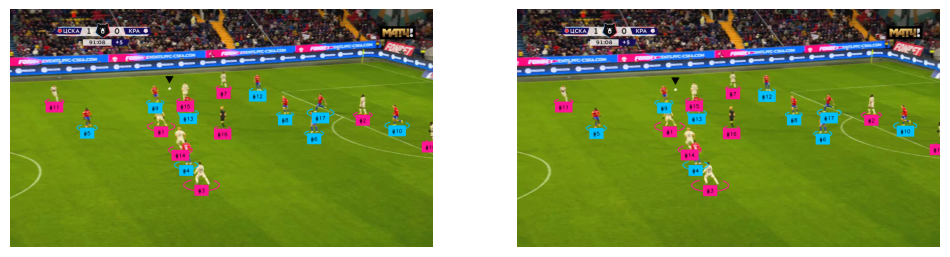

In [ ]:
from tqdm import tqdm
import supervision as sv

# убедиться, что classifier натренирован и processor готов

processor.frame_gen = sv.get_video_frames_generator(VIDEO_IN)
processor.tracker.reset()

annotated_frames = []
for _ in range(2):
    try:
        _, ann = processor.process_next()
    except StopIteration:
        break
    annotated_frames.append(ann)

sv.plot_images_grid(annotated_frames, grid_size=(1, 2))

In [ ]:
!ls -lh /content

total 12K
drwx------ 6 root root 4.0K May 14 17:38 drive
drwxr-xr-x 5 root root 4.0K May 14 17:33 RUT_futai
drwxr-xr-x 1 root root 4.0K May 13 13:39 sample_data
